# Sentiment analysis

This notebook describes the sentiment analysis steps that were undertaken. In the first part, we extract the sentiment of each quotes. In the second, we provide some descriptive statistics of the final dataset. After that, we go answering our research questions.

## Setup

In [138]:
# Built-in
import os
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')


# Third parties
import numpy as np
import pandas as pd
import nltk
from nltk import tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import platform
if platform.system() not in ('Darwin', 'Linux'):
    from pickle5 import pickle
import datetime
from datetime import timedelta

In [132]:
# Initialization needed for some modules

# tqdm for pandas
tqdm.pandas()

# NLTK configuration
nltk.download('vader_lexicon')
nltk.download('stopwords')
sia = SentimentIntensityAnalyzer()

# TokenSpace initialization
tokenSpace = tokenize.WhitespaceTokenizer()

plt.style.use("seaborn")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/AndreasPlesner/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/AndreasPlesner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
# Configuration
DATA_PATH = "data"
PKL_PATH = os.path.join(DATA_PATH, "pkl")
CSV_PATH = os.path.join(DATA_PATH, "csv")
RESOURCES_PATH = os.path.join(DATA_PATH, "resources")

In [50]:
# Utils functions

def get_sentiment(row: pd.Series) -> pd.Series:
    """
    Compute the sentiment score of a given row
    """   
    
    row['NLTK_score'] = sia.polarity_scores(row['quotation'])
    return row

def counter(text, columnText, quantity, label):
    allWords = ' '.join([text for text in text[columnText].astype('str')])
    tokenPhrase = tokenSpace.tokenize(allWords)
    frequency = nltk.FreqDist(tokenPhrase) 
    dfFrequency = pd.DataFrame({"Word": list(frequency.keys()), "Frequency": list(frequency.values())}) 
    
    dfFrequency = dfFrequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(15,3))
    ax = sns.barplot(data = dfFrequency, x = "Word", y = "Frequency", palette="deep")
    ax.set(ylabel = "Count")
    plt.xticks(rotation='horizontal')
    plt.title(f"Most common words for {label}")
    plt.show()

## 1. Compute sentiment score

Since we have all our extracted mentions dataset, we will simply load each year and create a final aggregated dataframe, since it is not too big (around 100k quotes).

In [51]:
if not os.path.exists(os.path.join(PKL_PATH, 'final_subset.pkl')):
    df_lst = []

    mentions = [os.path.join(CSV_PATH, f"20{i:02d}_mentions.csv") for i in range(15, 21)]  

    for mention in mentions:
        df_mention = pd.read_csv(mention)
        df_lst.append(df_mention)

    # Concatenate every year together
    df = pd.concat(df_lst) 

In a first place we'll use the Natural Language ToolKit (NLTK) package to do our sentiment analysis. It is using a rules-based approach which assigns to given words a specific sentiment rating which can be neutral, positive or negative (and its compound result). This is a pretty basic approach to scoring the sentiment of sentences but has the advantage of being easily applied and computed very fast.

In [52]:
# Compute the sentiment score
if not os.path.exists(os.path.join(PKL_PATH, 'final_subset.pkl')):
    df = df.progress_apply(get_sentiment, axis=1)
    

Remove NLTK columns

In [53]:
if not os.path.exists(os.path.join(PKL_PATH, 'final_subset.pkl')):
    NLTK_cols = [col for col in df.columns if 'NLTK' in col]
    if len(NLTK_cols) > 0:
        df = df.drop(NLTK_cols, axis=1)

In [54]:
# Sanity check
if not os.path.exists(os.path.join(PKL_PATH, 'final_subset.pkl')):
    df.sample(2)

In [55]:
if not os.path.exists(os.path.join(PKL_PATH, 'final_subset.pkl')):
    # Save the final dataframe both in csv and pickle
    df.to_pickle(os.path.join(PKL_PATH, "final_subset.pkl"))
    # df.to_csv(os.path.join(CSV_PATH, "final_subset.csv"))

Now that we have our final subset, we can conduct our exploratory data analysis on it.

## 2. Descriptive statistics

We will now perform some preliminary analysis, having in mind that we want to analyze the evolution of the sentiment scores accross time. We simply explore the data we have to deal with. We look at it in an aggregated way, not separated by party.

In [56]:
# To avoid running the above cells, we load the dataframe directly
# either from csv or pickle
if platform.system() in (('Darwin'), ('Linux')):
    # For Mac users :
    df = pd.read_pickle(os.path.join(PKL_PATH, "final_subset_flaired.pkl"))
else:
    ### For windows users :
    df = pickle.load(open("data/pkl/final_subset_flaired.pkl", "rb"))

events = pd.read_csv("data/events/events_weights.csv").iloc[:,1:5]

In [57]:
# Transform data type for further use
df['date'] = pd.DatetimeIndex(df['date'])#.normalize()
events['date'] = pd.DatetimeIndex(events['date'])#.normalize()

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105929 entries, 0 to 6361
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Unnamed: 0            105929 non-null  int64         
 1   quoteID               105929 non-null  object        
 2   quotation             105929 non-null  object        
 3   speaker               105929 non-null  object        
 4   qids                  105929 non-null  object        
 5   date                  105929 non-null  datetime64[ns]
 6   numOccurrences        105929 non-null  float64       
 7   probas                105929 non-null  object        
 8   urls                  105929 non-null  object        
 9   phase                 105929 non-null  object        
 10  subset                105929 non-null  bool          
 11  id                    82439 non-null   object        
 12  givenName             105929 non-null  object        
 13  f

We see that we have many columns (32!). We decided to keep everything for now, as we might need something. We will scrap some information later on.

In [59]:
df.sample(2)

,Unnamed: 0,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,...,position,stateName,parties,NLTK score,neg,neu,pos,compound,textblob_score,flair_score
592,156801,2017-06-23-087353,republicans weren't making the house bill bett...,elizabeth warren,['Q434706'],2017-06-23 12:20:07,1.0,"[['Elizabeth Warren', '0.8154'], ['None', '0.1...",['https://www.peoplespunditdaily.com/news/poli...,E,...,Senator,MA,Democrat,"{'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'comp...",0.000,0.707,0.293,0.4404,0.500000,-0.919877
16210,135703,2019-08-27-061177,"rep, [ sic ] elijah cummings has been a brutal...",president donald trump,['Q22686'],2019-08-27 11:48:40,2.0,"[['President Donald Trump', '0.6357'], ['None'...",['https://yubanet.com/opinions/john-a-tures-ba...,E,...,President,NaN,Republican,"{'neg': 0.287, 'neu': 0.624, 'pos': 0.089, 'co...",0.287,0.624,0.089,-0.9200,-0.429259,-0.999998


Here we see what a small sample of the data looks like.

In [60]:
print("Unique speakers count: ", len(df["speaker"].unique()))

Unique speakers count:  776


This count (776) unique speakers means that not every politician included in the congress biography list was quoted. We should also keep in mind that those are not truly "unique" speakers, since we currently have aliases for Donald Trump. In the future, we will have many more aliases for many of the speaker. Those aliases will be extracted using the `speaker_attributes` file.


In [61]:
trump_aliases = df[df["speaker"].str.contains("trump")]["speaker"].unique()
print("Number of current aliases for Trump: ", len(trump_aliases))
trump_aliases

Number of current aliases for Trump:  3


array(['donald trump', 'president trump', 'president donald trump'],
      dtype=object)

Next, we are interested about the sentiment scores.

In [62]:
sent_lst = ["neg", "neu", "pos", "compound"]
df[sent_lst].describe()

,neg,neu,pos,compound
count,105929.000000,105929.000000,105929.000000,105929.000000
mean,0.085498,0.817413,0.097087,0.046842
std,0.101861,0.127413,0.100218,0.515874
min,0.000000,0.133000,0.000000,-0.996500
25%,0.000000,0.735000,0.000000,-0.361200
50%,0.058000,0.822000,0.081000,0.000000
75%,0.140000,0.909000,0.155000,0.458800
max,0.835000,1.000000,0.756000,0.999000


For our analysis, we decided to only use the `compound` score, as it is the normalized final score of each separate score.
As we can see, most quotes are scored as "neutral". The median is perfectly at 0 and the mean is very similar. Below is the distribution illustrated:

Text(0, 0.5, 'count')

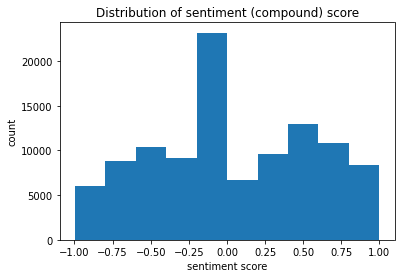

In [63]:
plt.hist(df["compound"])
plt.title("Distribution of sentiment (compound) score")
plt.xlabel("sentiment score")
plt.ylabel("count")

What about its evolution accross time?

In [64]:
df = df.reset_index(drop=True)
df["date"] = pd.to_datetime(df["date"])

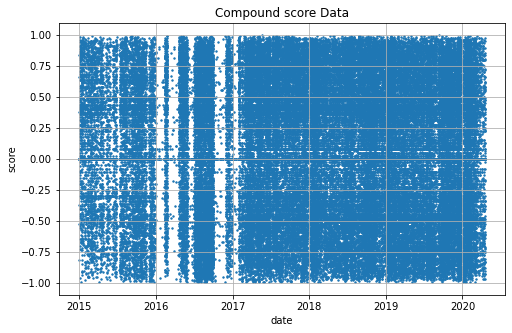

In [65]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(df["date"], df["compound"], s=2)

# Same as above
ax.set_xlabel('date')
ax.set_ylabel('score')
ax.set_title('Compound score Data')
ax.grid(True)

From what we visually see, there seems to be dates with almost no quotes before 2017. This probably comes from the quotebank dataset itself. We will need to keep that in mind when doing our analysis.

To further see if there is a trend with the compound score, we will compute the average per day.

In [66]:
# Date is currently precise to the second, but we simply want the date
df["date_simp"] = pd.DatetimeIndex(df['date']).normalize()
df["year"] = pd.DatetimeIndex(df['date']).year
df["year_zerod"] = df['year'] - df['year'].min()

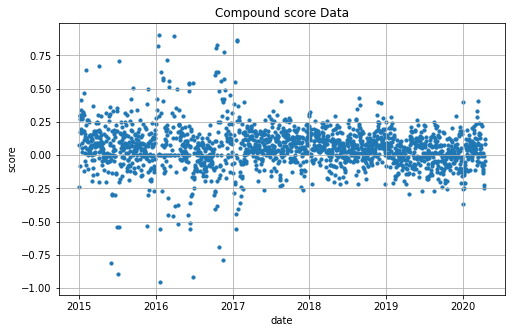

In [67]:
# Plot the average for each day
by_date = df.groupby(["date_simp"])["compound"].mean()

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(by_date.index, by_date, s=10)
ax.set_xlabel('date')
ax.set_ylabel('score')
ax.set_title('Compound score Data')
ax.grid(True)

With the aggregated data, we don't seem to see a trend (maybe a downward trend?). We do see, however, that the variance seem to be higher before 2017. Again, it is clear that this effect comes, in part, from the fact that some days seem to be missing.

We will now further analyze the dataset by exploring different things per party.

## 3. Sentiment analysis

In [68]:
# Split the df by party
party_grps = df.groupby('parties')
df_rep = df[df["parties"] == "Republican"]
df_dem = df[df["parties"] == "Democrat"]

In [69]:
for party, grp in party_grps:
    print(f'Number of {party} quotes: {len(grp)}')

Number of Democrat quotes: 49672
Number of Republican quotes: 56257


### 3.1 Quotes sentiment for each party (using NLTK)

The following distributions show the amount of quotes categorized in each sentiment categories (neutral, negative, positive). The axis represent the amount of certainty a quote is to be categorized as such. Therefore, quotes on the left side of the graph are uncertainly classified as its type while quotes on the right are highly likely to be classified in the right type, according to our sentiment analysis classifier. <br>

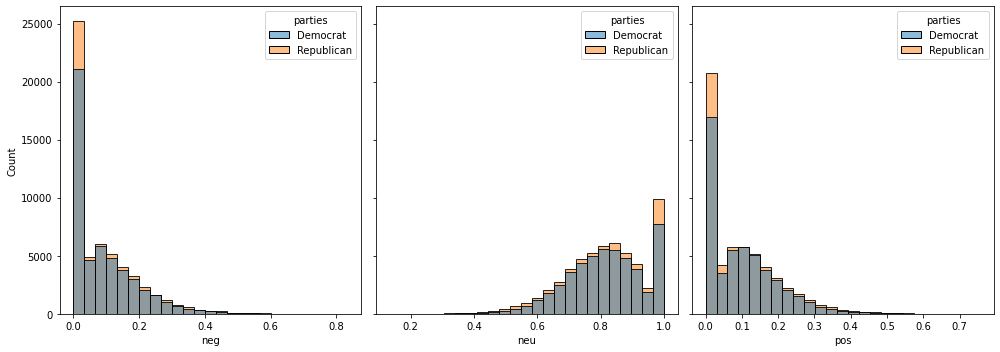

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(14,5), sharey=True)
sns.histplot(data=df, x='neg', hue='parties', ax=axes[0], bins=25)
sns.histplot(data=df, x='neu', hue='parties', ax=axes[1], bins=25)
sns.histplot(data=df, x='pos', hue='parties', ax=axes[2], bins=25)
fig.tight_layout()

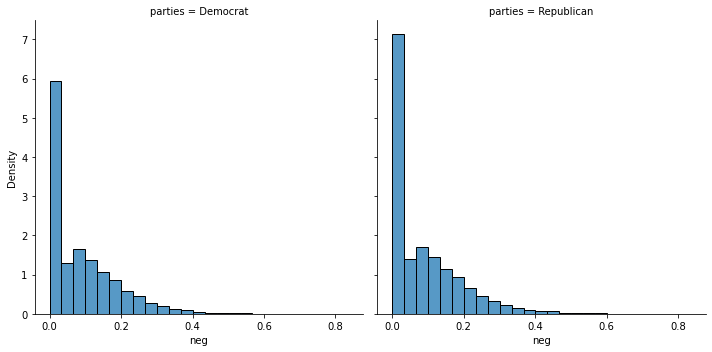

In [71]:
sns.displot(data=df, x='neg', stat='density', col='parties', bins=25, kind='hist', col_wrap=2);


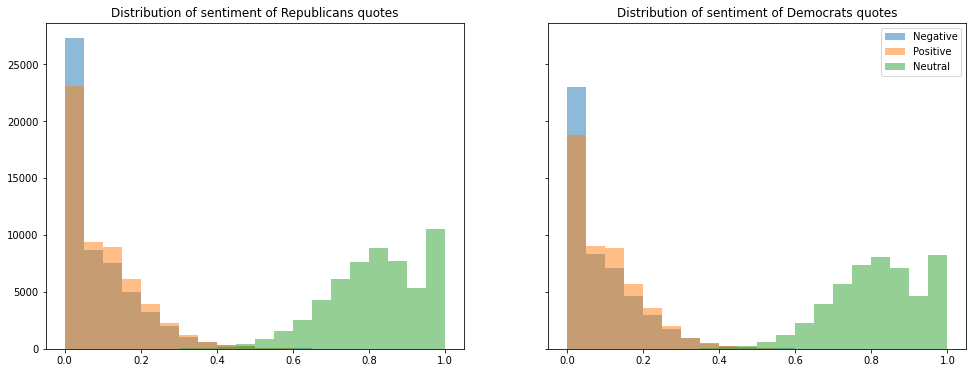

In [72]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(16.5,6))
# Overall distribution of republicans quotes sentiment
labels = ['neg','pos', 'neu']
axes[0].hist(df_rep['neg'], alpha=0.5, bins=np.arange(0, 1+1e-10, 0.05))
axes[0].hist(df_rep['pos'], alpha=0.5, bins=np.arange(0, 1+1e-10, 0.05))
axes[0].hist(df_rep['neu'], alpha=0.5, bins=np.arange(0, 1+1e-10, 0.05))
axes[0].set_title('Distribution of sentiment of Republicans quotes')
axes[1].hist(df_dem['neg'], alpha=0.5, bins=np.arange(0, 1+1e-10, 0.05))
axes[1].hist(df_dem['pos'], alpha=0.5, bins=np.arange(0, 1+1e-10, 0.05))
axes[1].hist(df_dem['neu'], alpha=0.5, bins=np.arange(0, 1+1e-10, 0.05))
labels = ['Negative','Positive', 'Neutral']
axes[1].set_title('Distribution of sentiment of Democrats quotes')
plt.legend(labels);

In [73]:
for name, value in zip(['Compound', 'Negative', 'Neutral', 'Positive'], ['compound', 'neg', 'neu', 'pos']):
    print(name)
    display(party_grps[value].describe())
    print(scipy.stats.ttest_ind(party_grps.get_group('Democrat')[value], party_grps.get_group('Republican')[value]))
    print('')

Compound


,count,mean,std,min,25%,50%,75%,max
parties,,,,,,,,
Democrat,49672.0,0.049648,0.518496,-0.9958,-0.3612,0.0,0.4767,0.9990
Republican,56257.0,0.044364,0.513539,-0.9965,-0.3612,0.0,0.4522,0.9989


Ttest_indResult(statistic=1.6638992520114593, pvalue=0.09613552248150549)

Negative


,count,mean,std,min,25%,50%,75%,max
parties,,,,,,,,
Democrat,49672.0,0.085746,0.099209,0.0,0.0,0.061,0.14025,0.737
Republican,56257.0,0.085280,0.104146,0.0,0.0,0.055,0.14000,0.835


Ttest_indResult(statistic=0.7428796097784959, pvalue=0.4575562190165472)

Neutral


,count,mean,std,min,25%,50%,75%,max
parties,,,,,,,,
Democrat,49672.0,0.816635,0.123868,0.133,0.735,0.820,0.904,1.0
Republican,56257.0,0.818099,0.130460,0.165,0.734,0.824,0.913,1.0


Ttest_indResult(statistic=-1.8662805000581908, pvalue=0.06200489271517315)

Positive


,count,mean,std,min,25%,50%,75%,max
parties,,,,,,,,
Democrat,49672.0,0.097616,0.097041,0.0,0.0,0.085,0.155,0.756
Republican,56257.0,0.096620,0.102940,0.0,0.0,0.077,0.156,0.737


Ttest_indResult(statistic=1.6139935028982755, pvalue=0.10653181416833096)



Not all quotes that where pos > neg have a positive compound nor is the opposite true

In [74]:
df = df.assign(
    pos_sentiment=lambda x: x.neg <= x.pos, 
    days_since_start=lambda x: (x.date_simp - df.date_simp.min()).dt.total_seconds()/(24*60*60)
)
df = df.assign(compound_check= lambda x: x.pos_sentiment == (x.compound >= 0))
print('Quotes with either compound < 0 and pos > neg or vice versa')
display(df[df['compound_check'] == False].sample(3)[['speaker', 'quotation', 'date', 'parties', 'neg', 'neu', 'pos', 'compound']])
print('# quotes with either compound < 0 and pos > neg or vice versa:', df['compound_check'].value_counts())

Quotes with either compound < 0 and pos > neg or vice versa


,speaker,quotation,date,parties,neg,neu,pos,compound
101974,david price,"over the last two years, we have watched the t...",2020-01-03 17:49:42,Democrat,0.122,0.751,0.127,-0.3400
27734,patrick leahy,republicans should not want to shut down the g...,2017-04-27 14:50:49,Democrat,0.093,0.818,0.089,0.1899
85321,president trump,check out maps... this nonsense has never happ...,2019-09-06 16:26:02,Republican,0.170,0.678,0.152,0.1710


# quotes with either compound < 0 and pos > neg or vice versa: True     104302
False      1627
Name: compound_check, dtype: int64


We can see that there are a lot of quotes classified as having a certainly neutral tone while the ones with a positive or negative tone are of small certainty. <br>
There seems to be overall a bit more negatively assigned quotes rather than positively, and that republicans have overall been more often critics of the opponent party than the democrats.

Next, we'll look at the compound sentiment value for each party accross each year of interest.

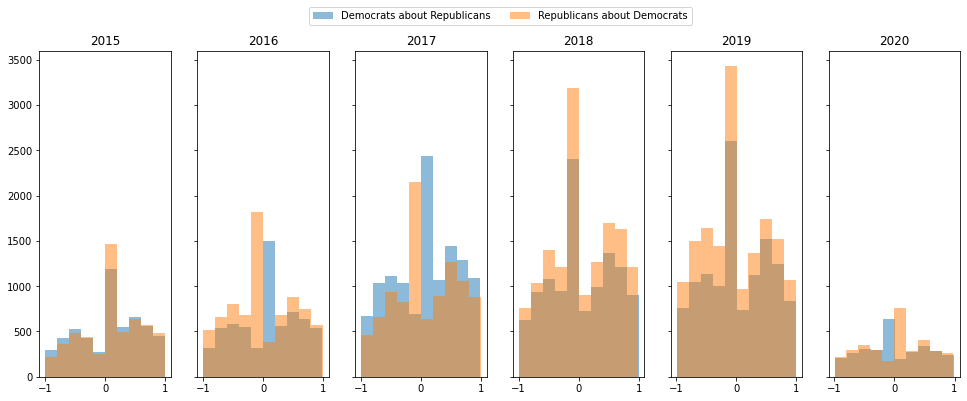

In [75]:
year = 2015
fig, axes = plt.subplots(1, 6, sharey=True, figsize=(16.5,6))
for i in range(0,6):
    axes[i].hist(df_dem[df_dem['date'].astype(str).str.contains(f"{year}")]['compound'], alpha = 0.5, label ="Democrats about Republicans");
    axes[i].hist(df_rep[df_rep['date'].astype(str).str.contains(f"{year}")]['compound'], alpha=0.5, label ="Republicans about Democrats");
    axes[i].set_title(f"{year}");
    year += 1
axes[0].legend(bbox_to_anchor =(5, 1.15), ncol = 2)

The various distributions of quotes sentiment scores over each year show us 2 things. <br>
First, except for the year 2020 (for which we lack data), there have been more and more quotes coming from either party mentionning the opposition one. <br>
Second, that depending on the year we see different amount of quote mentionning the other party. Indeed, in 2015 the distributions look pretty similar in shape (with the increase); from 2016 to 2019, we've extracted more quotes about republicans mentionning democrats rather than the opposite, except in 2017 where democrats seem to have been more actively speaking about their opponent. This can be explained by the presidential election that occurred in the beggining of this year and the following criticism the newly president may have faced (especially with his controversial ideas about Muslim-majority nations travel ban, Mexico wall..). <br>
We'll later dive deeper in this direction and check the consequence on these distributions of specific events.

### 3.2 Most common words analysis

Here we take a look at the words the most used by each party. 

In [76]:
#remove and keep some of the stopwords
stop = stopwords.words("english")

# Add to the stopword list common words an punctuation that is present for both emotions
stop = stop + ["going", "would", "want", "get", "one", "-", "_", "[", "]"]

df_rep = df_rep.assign(quotation_clean=df_rep["quotation"].apply(lambda x: " ".join(x for x in x.split() if x not in stop)))
df_dem = df_dem.assign(quotation_clean=df_dem["quotation"].apply(lambda x: " ".join(x for x in x.split() if x not in stop)))

These histograms show those most common words after a first sorting where we've removed common english stopwords (mostly determinants, common verbs and punctuation). These words mostly refers to the opponent party title or its leading member. A further investigation by focusing on certain periods or removing even more general terms could reveal more intense words or speach patterns.

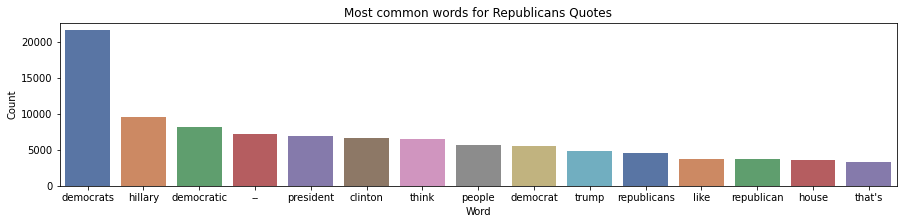

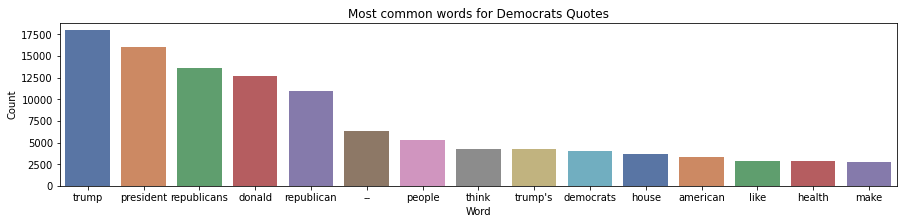

In [77]:
counter(df_rep, 'quotation_clean', 15, 'Republicans Quotes')
counter(df_dem, 'quotation_clean', 15, 'Democrats Quotes')

### 3.3 Regression

In [78]:
mean_compound_score = df.groupby('date_simp').mean()['compound']
mean_compound_score_pos = df[df['pos_sentiment'] == True].groupby('date_simp').mean()['compound']
mean_compound_score_neg = df[df['pos_sentiment'] == False].groupby('date_simp').mean()['compound']
mean_compound_score_late = mean_compound_score[mean_compound_score.index > np.datetime64('2018-01-01')]

#### 3.3.1 Data overview

We may firstly look at if we visually can see any trends in the data. For this we look at the compound scores over time. 
We make three plots, the first two split the data based on whether pos > neg (i.e. positive sentiment) while the third only looks at the score in 2017 to show greater details without splitting the data based on the positive sentiment. We also include confidence intervals which we notice are very wide. 


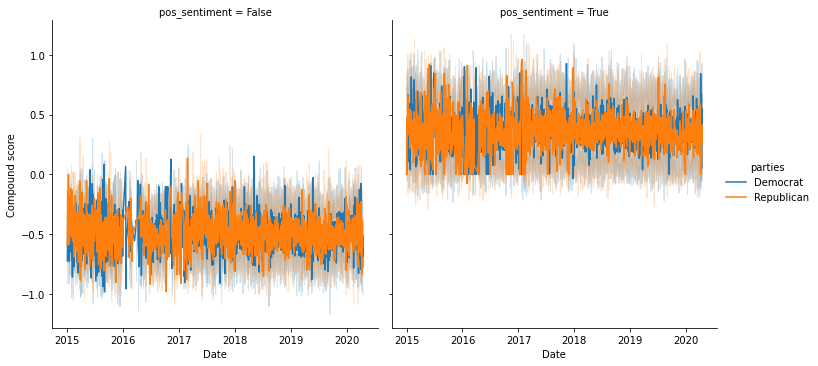

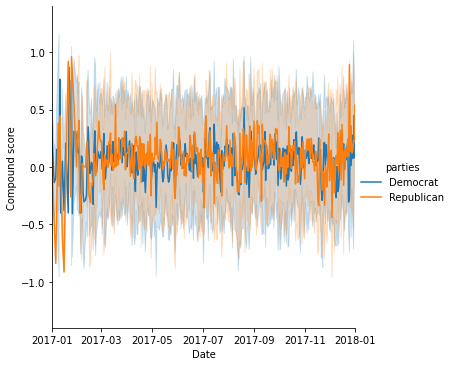

In [79]:
g = sns.relplot(data=df, x='date_simp', y='compound', hue='parties', kind='line', ci='sd', col='pos_sentiment')
g.set_xlabels('Date')
g.set_ylabels('Compound score')
g = sns.relplot(data=df, x='date_simp', y='compound', hue='parties', kind='line', ci='sd')#, col='pos_sentiment')
g.set_xlabels('Date')
g.set_ylabels('Compound score')
for ax in g.axes.flatten():
    ax.set_xlim((np.datetime64('2017-01-01'), np.datetime64('2018-01-01')))

Above the plots shows few differences between the parties, so plots going further will not distinguish between the parties.
The above plots also show some slight oddities around 2016-2017, which are clearest for the third plot so we plot the compound score by plotting the compound score averaged for all quotes on a given day.
Furthermore, we also plot the histogram of number of quotes over time. The plot is a stacked histogram with groups based on whether the quote has pos >= neg. 

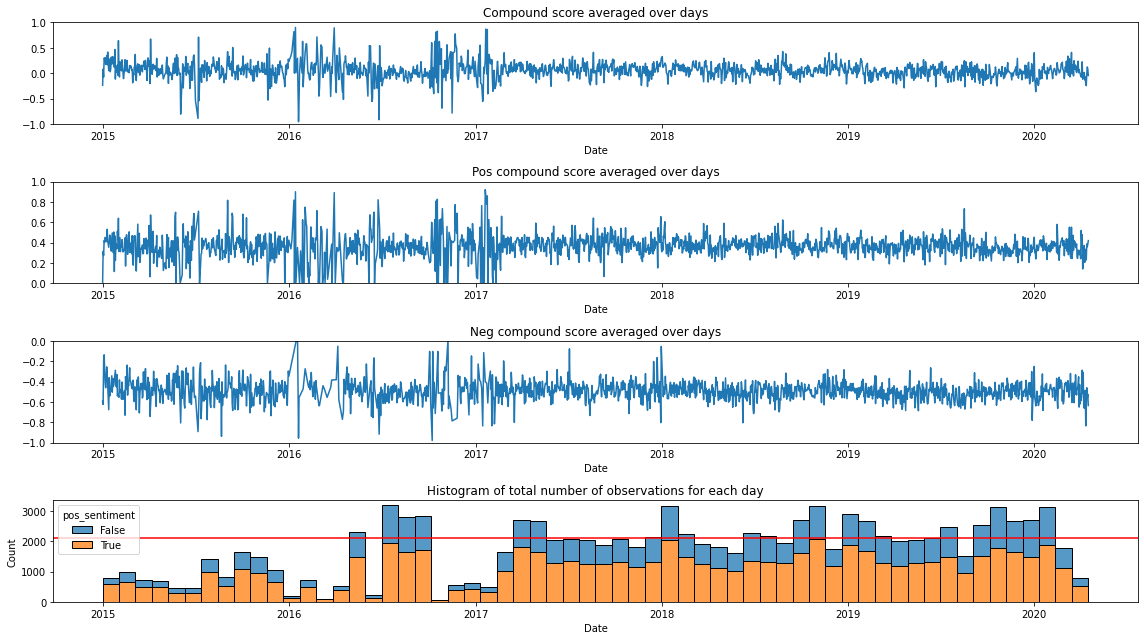

In [80]:
fig, axes = plt.subplots(4,1,figsize=(16,9))
ax = axes[0]
ax.plot(mean_compound_score)
ax.set_title('Compound score averaged over days')
ax.set_xlabel('Date')
ax.set_ylim((-1, 1))

ax = axes[1]
ax.plot(mean_compound_score_pos)
ax.set_title('Pos compound score averaged over days')
ax.set_xlabel('Date')
ax.set_ylim((0, 1))

ax = axes[2]
ax.plot(mean_compound_score_neg)
ax.set_title('Neg compound score averaged over days')
ax.set_xlabel('Date')
ax.set_ylim((-1, 0))

ax = axes[3]
sns.histplot(data=df, x='date_simp', axes=ax, hue="pos_sentiment", multiple="stack", bins=60)
ax.set_xlabel('Date')
ax.set_title('Histogram of total number of observations for each day')
# ax.set_yscale('log')
ax.axhline(len(df)/50, color='r', label='Mean bin count')

fig.tight_layout()

The oddities become a lot clearer now, and, as also mentioned earlier, we notice immediately from the histogram that many of the oddities coincides times where we have relatively few quotes (e.g. end of 2016).

We will come back to this later. Firstly we will fit some basic functions.

#### 3.3.2 Fitting simple functions

It is hard to see if a linear trend would be appropiate, but as this is a very simple initial structure we will test these on subsets of the data.

In [81]:
res = smf.ols('compound ~ days_since_start', data=df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               compound   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     114.7
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           9.39e-27
Time:                        12:06:21   Log-Likelihood:                -80135.
No. Observations:              105929   AIC:                         1.603e+05
Df Residuals:                  105927   BIC:                         1.603e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0850      0.004  

In [115]:
grps = df.groupby(['parties'])
results = {}
results_year = {}
for label, grp in grps:
    res = smf.ols('compound ~ days_since_start', data=grp).fit()
    results[label] = res
    res = smf.ols('compound ~ year_zerod', data=grp).fit()
    results_year[label] = res

In [118]:
print('Best results for:', 'Republican')
print(results['Republican'].summary())

for label, res in results.items():
    print(label)
    print(res.summary())

Best results for: Republican
                            OLS Regression Results                            
Dep. Variable:               compound   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     120.5
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           5.36e-28
Time:                        12:45:28   Log-Likelihood:                -42273.
No. Observations:               56257   AIC:                         8.455e+04
Df Residuals:                   56255   BIC:                         8.457e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept  

The results are not great, as the R^2 in all cases is 0.00. We get for both models a significant slope coefficient. 

For democrats we get that the intercept corresponding to the mean compound score at the time of the first quote is 0.0697 while the slope is -1.8e-5 i.e. the compound decrease on average by 6.57e-3 every 365 days (roughly one year).
For republicans we get that the intercept corresponding to the mean compound score at the time of the first quote is 0.0986 while the slope is -4.695e-5 i.e. the compound decrease on average by 1.71e-2 every 365 days (roughly one year).
Hence the republicans start of being more positive of their collegues, but their slope is more negative and hence after 2 years and 9 months (end of 2017) the republicans would be more aggresive.

We can then try using the year (zerod such that 2015 is 0) as the explanatory variable.


In [84]:
print('Best results for:', 'Republican')
print(results_year['Republican'].summary())

for label, res in results_year.items():
    print(label)
    print(res.summary())

Best results for: (False, 'Republican')
                            OLS Regression Results                            
Dep. Variable:               compound   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     10.21
Date:                Thu, 16 Dec 2021   Prob (F-statistic):            0.00140
Time:                        12:06:22   Log-Likelihood:                -1381.8
No. Observations:               20864   AIC:                             2768.
Df Residuals:                   20862   BIC:                             2783.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

This does not really change the results from above

#### 3.3.3 Spectral analysis

Taking another look at the figure we get the idea that there might be some seasonaility/periodicity in play. We therefore calculate the fourier spectrum, ACF and PACF. For the last two we consider lags up to 375 to be able to see any yearly effects.

(0.0, 0.5)

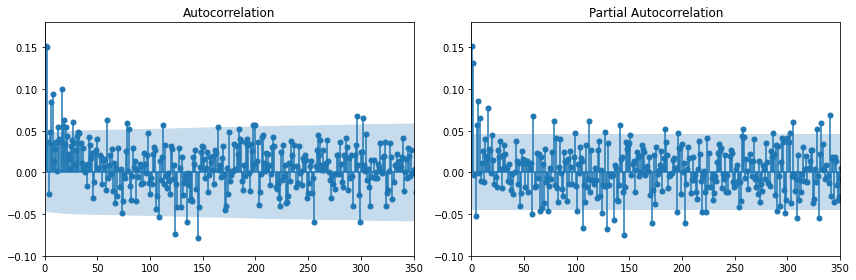

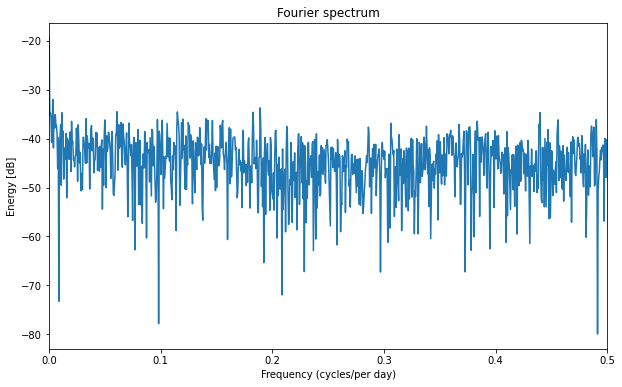

In [85]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
ax = axes[0]
plot_acf(mean_compound_score, ax=ax, lags=375)
ax.set_xlim((0, 350))
ax.set_ylim((-0.10, 0.18))
ax = axes[1]
plot_pacf(mean_compound_score, ax=ax, lags=375)
ax.set_xlim((0, 350))
ax.set_ylim((-0.10, 0.18))
fig.tight_layout()

fig, ax = plt.subplots(1,1,figsize=(10,6))
N, T = len(mean_compound_score), 1
mean_compound_score_fft = scipy.fft.fft(mean_compound_score.values)
mean_compound_score_freq = scipy.fft.fftfreq(N, T)[:N//2]
ax.plot(mean_compound_score_freq, 20*np.log10(2.0/N * np.abs(mean_compound_score_fft[:N//2])))
ax.set_xlabel('Frequency (cycles/per day)')
ax.set_ylabel('Energy [dB]')
ax.set_title('Fourier spectrum')
ax.set_xlim((0, 0.5))


The fourier spectrum is very noisy and it is therefore hard to say which if any frequencies should be dominating. However, it seems like there could be some dominating frequencies in the lower end. 
The ACF and PACF indicate that maybe an ARMA model would describe the data well. However, it is not clear what order the model should be. 

An ARMA model describes (weakly) stationary data [1,2] and we therefore focus on the data from 2018 and forward because as we saw in 2016 and 2017 there were months with were little data and hence the daily-averaged compound score was disturbed.

We then replicate the ACF and PACF plots from above on only the data from 2018 and forward.

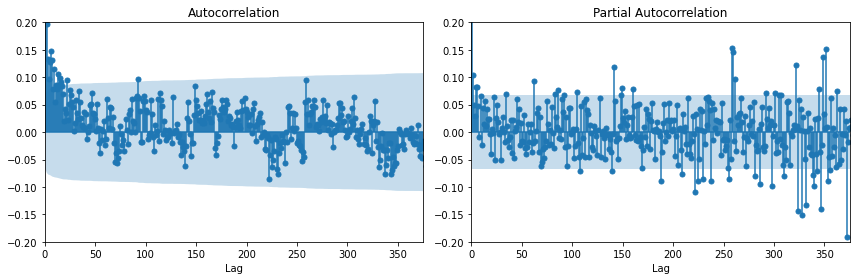

In [86]:
fig, axes = plt.subplots(1,2,figsize=(12,4)) 
ax = axes[0]
plot_acf(mean_compound_score_late, ax=ax, lags=400)
ax = axes[1]
plot_pacf(mean_compound_score_late, ax=ax, lags=400)

for ax in axes.flatten():
    ax.set_xlim((0, 375))
    ax.set_ylim((-0.2, 0.2))
    ax.set_xlabel('Lag')

fig.tight_layout()

# fig, ax = plt.subplots(1,1,figsize=(10,6))
# N, T = len(mean_compound_score_late), 1
# mean_compound_score_fft = scipy.fft.fft(mean_compound_score_late.values)
# mean_compound_score_freq = scipy.fft.fftfreq(N, T)[:N//2]
# ax.plot(mean_compound_score_freq, 20*np.log10(2.0/N * np.abs(mean_compound_score_fft[:N//2])))
# ax.set_xlabel('Frequency (cycles/per day)')
# ax.set_ylabel('Energy [dB]')
# ax.set_title('Fourier spectrum')
# ax.set_xlim((0, 0.5))

There definitly seems to be something at low p's and q's in the ARMA(p,q) but there also seems to be a seasonal component to the AR with a seasonaility around a year (lag 365).

To check to low orders we can plot y(t) against y(t+k) for k = 1,2,3 where y(t) is the daily-averaged compound on day t.

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 365)'>

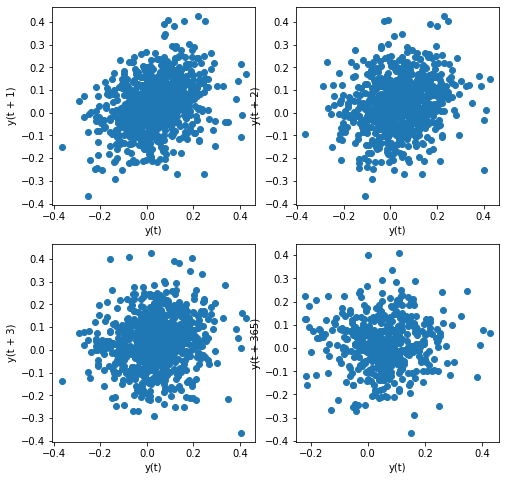

In [87]:
fig, axes = plt.subplots(2,2,figsize=(8,8))
ax = axes[0,0]
pd.plotting.lag_plot(mean_compound_score_late, ax=ax, lag=1)
ax = axes[0,1]
pd.plotting.lag_plot(mean_compound_score_late, ax=ax, lag=2)
ax = axes[1,0]
pd.plotting.lag_plot(mean_compound_score_late, ax=ax, lag=3)
ax = axes[1,1]
pd.plotting.lag_plot(mean_compound_score_late, ax=ax, lag=365)

#### 3.3.4 Fitting ARMA model

The above showed that an ARMA(p,q) with some seasonaility with a period around 365 days.

                               SARIMAX Results                                
Dep. Variable:               compound   No. Observations:                  836
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 695.564
Date:                Thu, 16 Dec 2021   AIC                          -1381.127
Time:                        13:11:58   BIC                          -1357.484
Sample:                    01-02-2018   HQIC                         -1372.064
                         - 04-16-2020                                         
Covariance Type:               approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0399      0.011      3.579      0.000       0.018       0.062
ar.L1          1.1592      0.058     19.935      0.000       1.045       1.273
ar.L2         -0.1943      0.044     -4.427      0.0

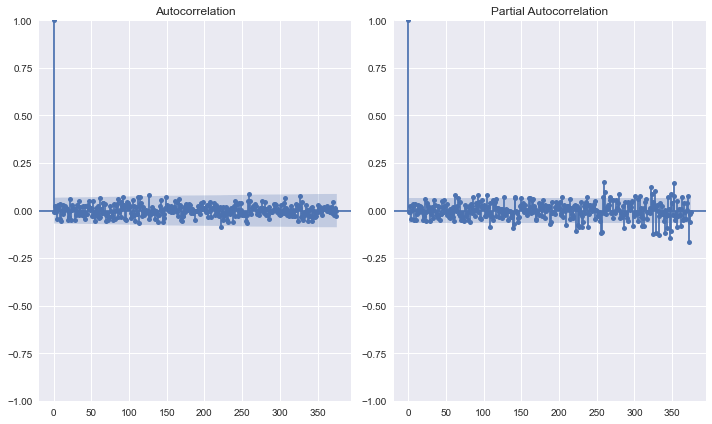

In [135]:
arma_mod = ARIMA(mean_compound_score_late, order=(2, 0, 1), trend="c")
arma_res = arma_mod.fit(low_memory=True)
print(arma_res.summary())
fig, axes = plt.subplots(1,2,figsize=(10,6))
plot_acf(arma_res.forecasts_error.flatten(),ax=axes[0], lags=375)
plot_pacf(arma_res.forecasts_error.flatten(),ax=axes[1], lags=375)
fig.tight_layout()

In [146]:
mean_compound_score.index[-1]

Timestamp('2020-04-16 00:00:00')

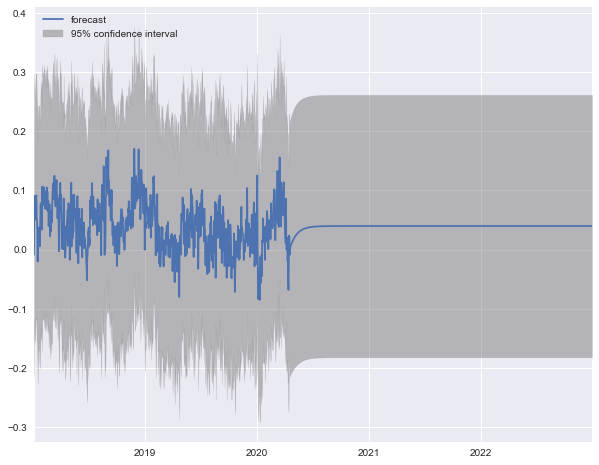

In [145]:
fig, ax = plt.subplots(figsize=(10, 8))
fig = plot_predict(arma_res, start="2018-01-02", end="2020-04-16", ax=ax)
ax.plot(mean_compound_score, label='Observed')
legend = ax.legend(loc="upper left")

### 3.4 Aggressivity by speaker analysis

This section answers the question: "Which politicians are the least or the most aggressive?". We should strongly emphasize the fact that we consider a politician as being "aggressive" if she or he has an overall negative sentiment score, which is quite a shortcut. Unfortunately, the scope of the project did not allow us to provide a semantic analysis of the quotes to see if a negative quote also means, on average, that the vocabulary used and the speaker are more aggressive.

Let us start by simply analyzing the most negative scores for all speakers throughout the whole dataset.

In [89]:
most_agg = df.groupby(["speaker", "parties"]).agg({
    "compound": "mean",
    "speaker": "size", 
}) \
.rename({"speaker": "quotes_count"}, axis=1) \
.sort_values("compound")

most_agg.head(5)

,,compound,quotes_count
speaker,parties,,
robert hayes,Republican,-0.8910,1
david hobson,Republican,-0.7841,1
ron lewis,Republican,-0.7783,1
john shadegg,Republican,-0.7351,1
heath shuler,Democrat,-0.6249,1


As we can see, most extremely negative (and thus aggressive by our methodology) speakers are such because they only have one quote to their names. So we will only consider those with at least 100 quotes.

In [90]:
most_agg = most_agg[most_agg["quotes_count"] >= 100]
# Only keep those really negative
threshold = -0.05
most_agg = most_agg[most_agg["compound"] <= threshold].sort_values("compound")
most_agg

,,compound,quotes_count
speaker,parties,,
barbara lee,Democrat,-0.211459,182
tulsi gabbard,Democrat,-0.139305,332
joe walsh,Republican,-0.096052,105
elijah cummings,Democrat,-0.095461,936
maxine waters,Democrat,-0.090463,480
bennie thompson,Democrat,-0.087981,129
pramila jayapal,Democrat,-0.073166,270
claudia tenney,Republican,-0.070770,117
john yarmuth,Democrat,-0.070638,226


In [91]:
# Compute count and proportion by party
g = pd.DataFrame(most_agg.groupby("parties").size()).rename({0: "count"}, axis=1)
g["proportion"] = g["count"] / g["count"].sum()
g

,count,proportion
parties,,
Democrat,14,0.823529
Republican,3,0.176471


It clearly came as a surprise to us that the democrats seems to be the most aggressive ones when mentioning another politician from the other party. In the next section, we focus on the 3 most aggressive speakers.

#### EDA of most aggressive speakers

It seems that the following speakers are specifically negative and thus, polarizing when they are mentioning people of the other political camp:
- [Barbara Lee](https://en.wikipedia.org/wiki/Barbara_Lee) (Democrat)
- [Tulsi Gabbard](https://en.wikipedia.org/wiki/Tulsi_Gabbard) (Democrat)
- [Joe Walsh](https://en.wikipedia.org/wiki/Joe_Walsh_(Illinois_politician)) (Republican)

To explore that, let us explore a few random quotes from them.

In [92]:
speakers = ["barbara lee", "tulsi gabbard", "joe walsh"]

for speaker in speakers:
    print("Samples from", speaker)
    quotes = df[df["speaker"] == speaker].sample(3)[["quoteID", "compound", "quotation"]].values
    for q in quotes:
        print(f"QID: {q[0]}, Score: {q[1]} \n \"{q[-1]}\"\n")
    print("-" * 30)

Samples from barbara lee
QID: 2017-03-23-001150, Score: -0.0772 
 "40,000 u.s. women will die from breast cancer this year. but republicans think taking away coverage for mammograms is funny."

QID: 2016-09-29-023399, Score: 0.0 
 "donald trump's presidential campaign has been based on the birther campaign, which he founded,"

QID: 2017-05-01-076099, Score: -0.5994 
 "president trump doesn't understand why there was a civil war,"

------------------------------
Samples from tulsi gabbard
QID: 2018-04-27-087965, Score: 0.1005 
 "nothing is more important to the american people than peace. unfortunately, there are some calling for preconditions and delays to president trump's meeting with chairman kim. they clearly do not understand the urgency of the situation and the seriousness of the threat posed to the people of hawai‘i and this country. we must build on the momentum of today's historic summit, with president trump and kim jong-un's upcoming meeting so that we may achieve denucleari

By doing that multiple times (we only extracted 3 quotes by politican here), we can observe a few things. First, our method seems to capture well the polarization between the two political camps:
- Tulsi Gabbard (QID: 2019-09-25-056870, Score: -0.3182):
> it's important that donald trump is defeated,
- Barbara Lee (QID: 2015-09-16-064526 Score: -0.743):
> it's past time that republicans stop governing by crisis,
- Joe Walsh (QID: 2019-08-24-040425, Score: -0.3818):
> the truth: as practiced by most muslims, islam is not a religion. these muslims are at war w us. barack obama, a muslim, is on their side,

In some cases, though, this process outlined some clear problems:
- Barbara Lee (QID: 2020-04-16-025948 Score: **0.8074**)
>instead of giving relief to americans who are struggling to make ends meet, senate republicans snuck in tax breaks and corporate giveaways for their wealthy friends,
    - This quote should be negative and is a clear example of polarizing quote. It is not detected as such by our algorithm.
- Tulsi Gabbard (QID: 2019-04-30-091725, Score: -0.4927)
> the most attacks i get are not from republicans,
    - Although she mentions republicans, this quote is actually not in favor of them, but is actually _in favor_ of republicans.
    
Those are just some examples that we wanted to outline to show some shortcomings of our algorithm. Those points could be further investigated in future work.

Now that we analyzed the aggressivity in bulk, chapter 3.1 of this notebook indicated that there seems to be a great change through the years. So we now do a similar analysis of the most aggressive speakers per year.


#### Most aggressive speakers by year

By using the same methodology as the previous point, we extract only the most aggressive speakers with at least 100 quotes and with a mean score of at least -0.05.

In [93]:
# create new "year" column in df
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

In [94]:
# Sanity check
df.sample(1)

,Unnamed: 0,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,...,pos,compound,textblob_score,flair_score,date_simp,year,year_zerod,pos_sentiment,days_since_start,compound_check
50161,372501,2018-11-01-099049,that means he's with donald trump in wanting t...,elizabeth warren,['Q434706'],2018-11-01 00:05:00,16.0,"[['Elizabeth Warren', '0.522'], ['None', '0.37...",['http://lasvegassun.com/news/2018/nov/01/sen-...,E,...,0.122,0.4939,0.0,0.927247,2018-11-01,2018,3,True,1400.0,True


In [95]:
most_agg = df.groupby(["year", "speaker", "parties"]).agg({
    "compound": "mean",
    "speaker": "size", 
}) \
.rename({"speaker": "quotes_count"}, axis=1) \
.sort_values("compound")

most_agg = most_agg[most_agg["quotes_count"] >= 100]
# Only keep those really negative
threshold = -0.05
most_agg = most_agg[most_agg["compound"] <= threshold].sort_values("year")

In [96]:
# Display table
most_agg

compound  quotes_count
year speaker                  parties                           
2015 elijah cummings          Democrat   -0.339667           201
2016 elijah cummings          Democrat   -0.188794           132
     donald trump             Republican -0.052753          4094
2017 jeff flake               Republican -0.111487           133
     ted lieu                 Democrat   -0.077877           100
     cory booker              Democrat   -0.078286           132
     jeanne shaheen           Democrat   -0.056756           100
     barbara lee              Democrat   -0.232446           104
     kirsten gillibrand       Democrat   -0.074496           156
     maxine waters            Democrat   -0.114713           180
2018 orrin hatch              Republican -0.075000           137
     ted lieu                 Democrat   -0.061465           109
     dianne feinstein         Democrat   -0.083949           318
     mazie hirono             Democrat   -0.119052           102
     kirsten gillibrand       Democrat   -0.120604           140
     maxine waters            Democrat   -0.122643           164
     adam smith               Democrat   -0.054608           106
     jerrold nadler           Democrat   -0.116621           131
     richard blumenthal       Democrat   -0.072185           227
2019 president donald trump   Republican -0.057747          3823
     devin nunes              Republican -0.062832           476
     kamala harris            Democrat   -0.054848           169
     xavier becerra           Democrat   -0.173166           116
     rashida tlaib            Democrat   -0.054251           107
     elise stefanik           Republican -0.097369           157
     mo brooks                Republican -0.120918           171
     tulsi gabbard            Democrat   -0.126019           205
     john ratcliffe           Republican -0.129743           117
     alexandria ocasio-cortez Democrat   -0.082365           279
     donald trump             Republican -0.080294           987

In [97]:
g = pd.DataFrame(most_agg.groupby(["year", "parties"]).size()).rename({0: "count"}, axis=1)
g["proportion"] = g["count"] / g.groupby("year")["count"].sum()
g

count  proportion
year parties                      
2015 Democrat        1    1.000000
2016 Democrat        1    0.500000
     Republican      1    0.500000
2017 Democrat        6    0.857143
     Republican      1    0.142857
2018 Democrat        8    0.888889
     Republican      1    0.111111
2019 Democrat        5    0.454545
     Republican      6    0.545455

The first thing we observe is that we have only one speaker denoted as "aggressive" in 2015. This comes from the fact that we have fewer quotes in earlier year (2015 and 2016, see section 3.1). Also, it appears that we did not have enough data in 2020 to extract meaningful insights. 

In 2017 and 2018, aggressive speakers are overwhelmingly democrats. Only one republican is denoted as aggressive. In 2019, we have an exact parity between democrats and republicans. Indeed, Donald Trump is counted twice, once under "donald trump" and once under "president donald trump". 

From the most aggressive table, we clearly see that something seems to have happened around 2016 (Trump's election?) which seems to have (1) greatly increased the number of quotes about the other camp by politicians and, (2) greatly increased the number of aggressive speakers (democrats in that case). In 2019, republicans **seem to have responded to that aggressivity** by also being aggressive. We will continue to explore the evolution of the score around key events in the next section.  

### 3.5 Evolution of score around key events

_Refer to `events_dataset.ipynb` to see how the events dataset was created._

#### Distribution of the compound scores a week before and after every key events

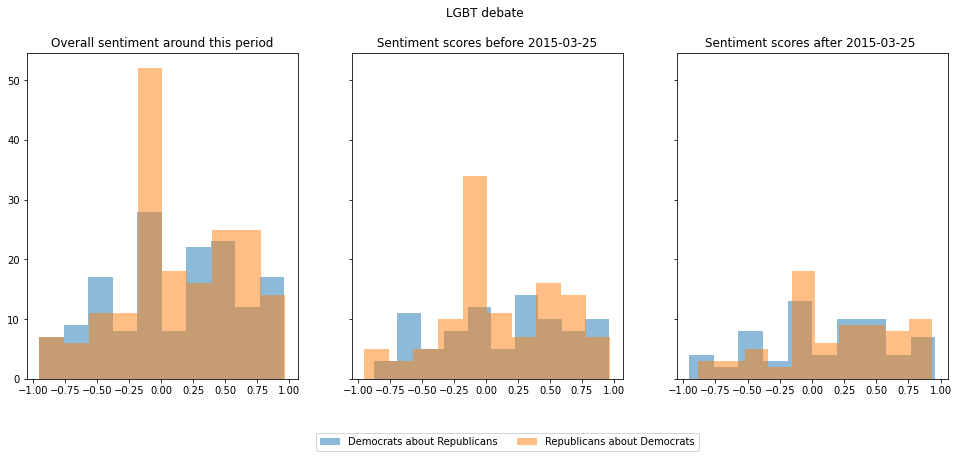

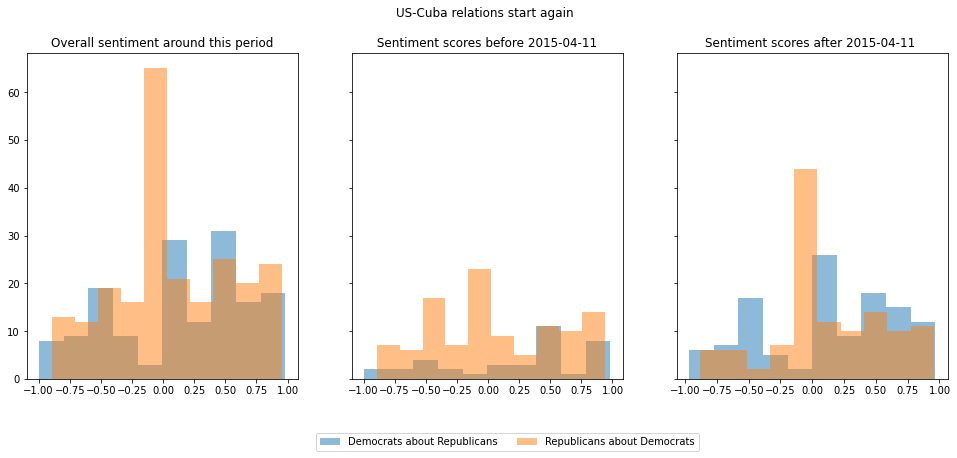

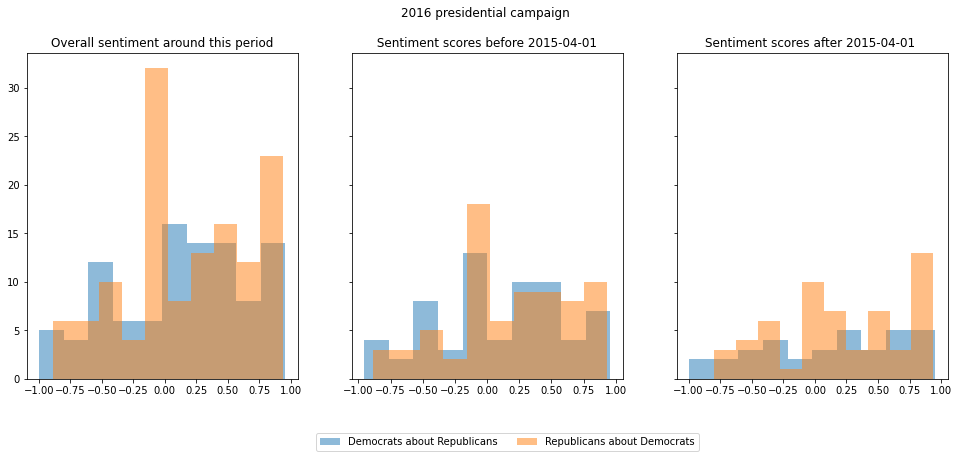

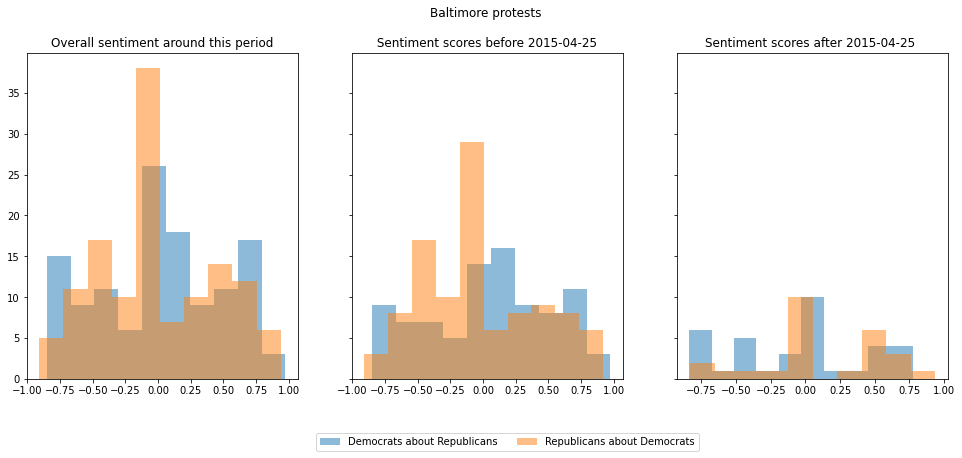

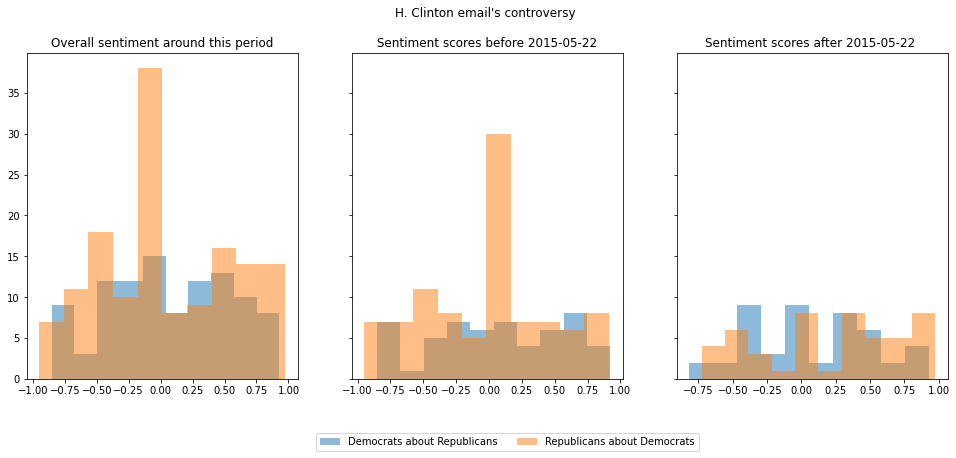

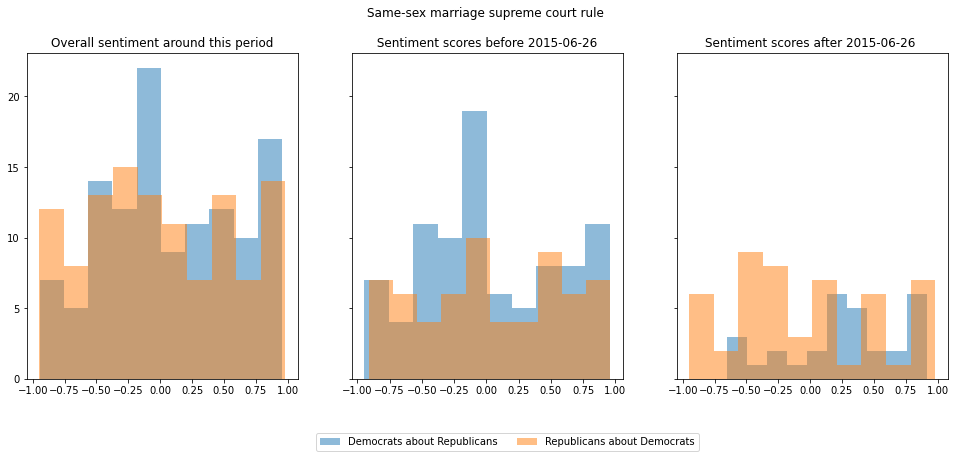

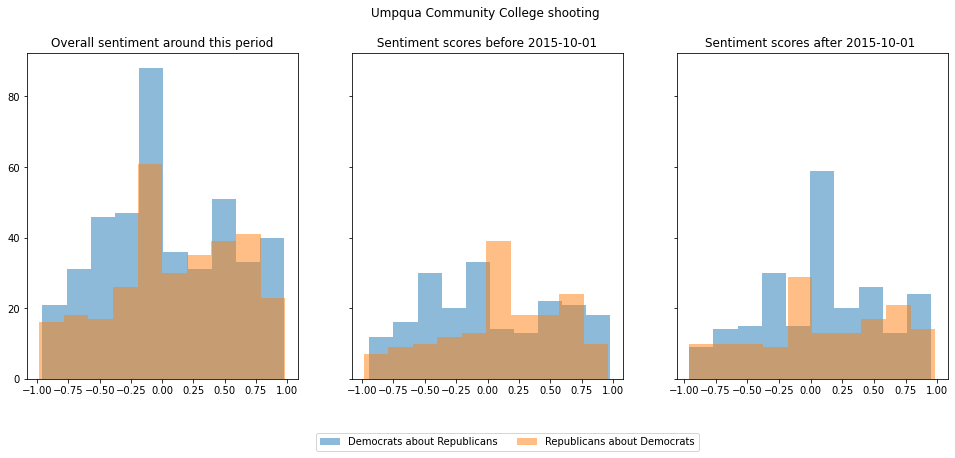

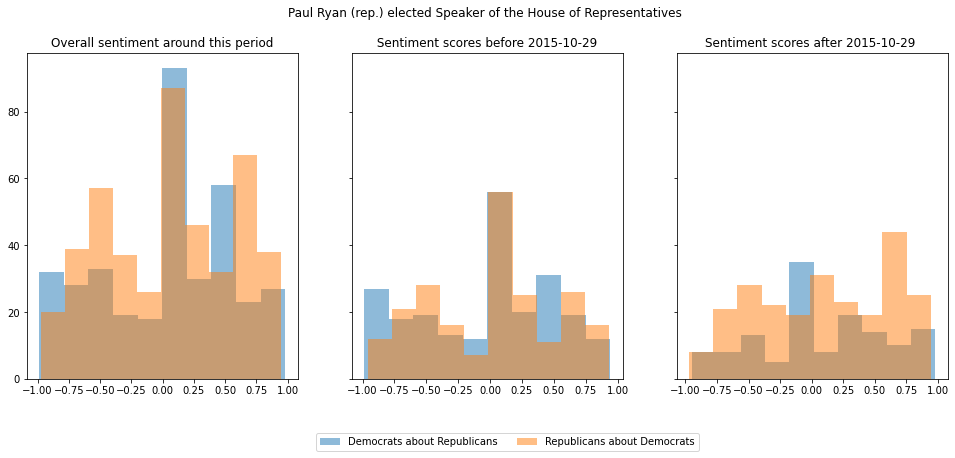

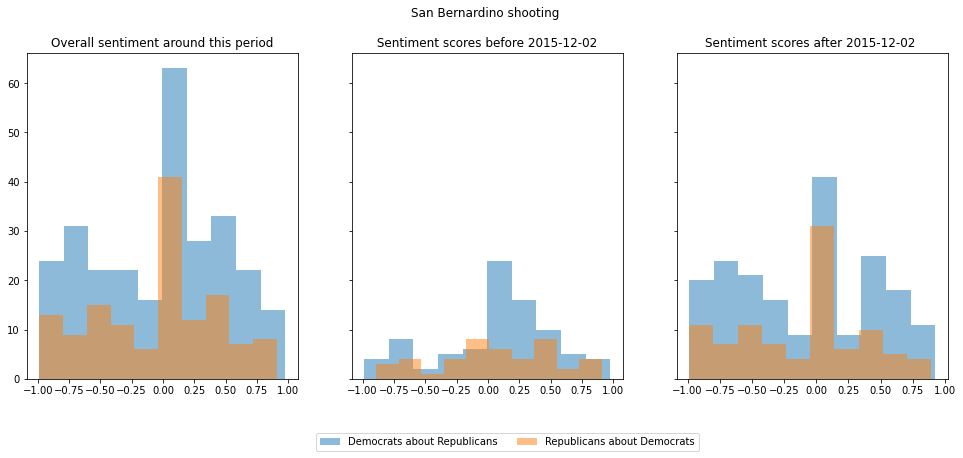

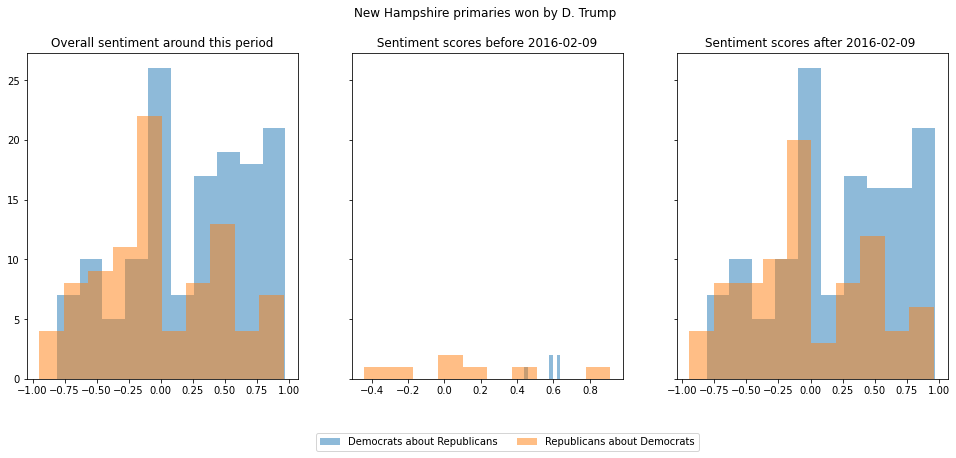

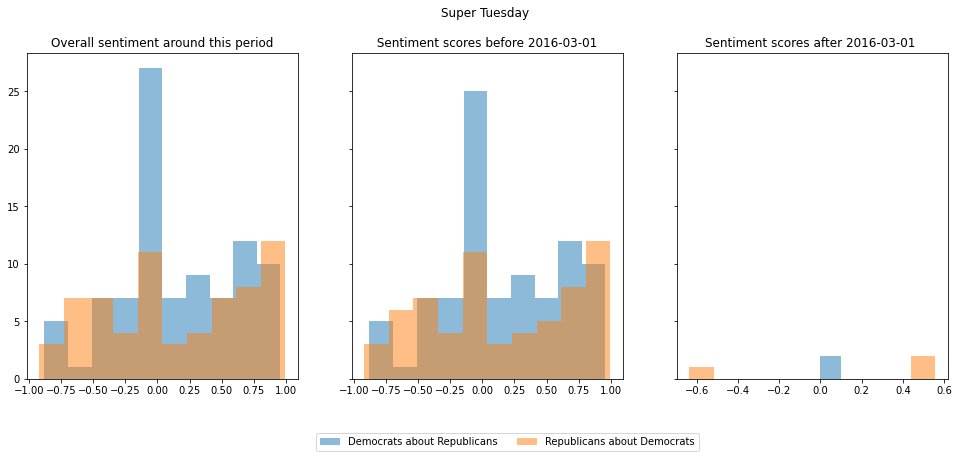

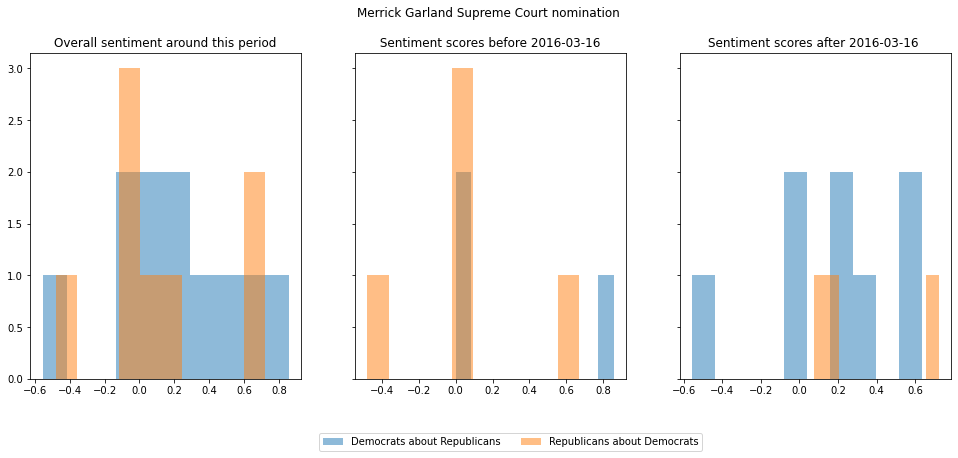

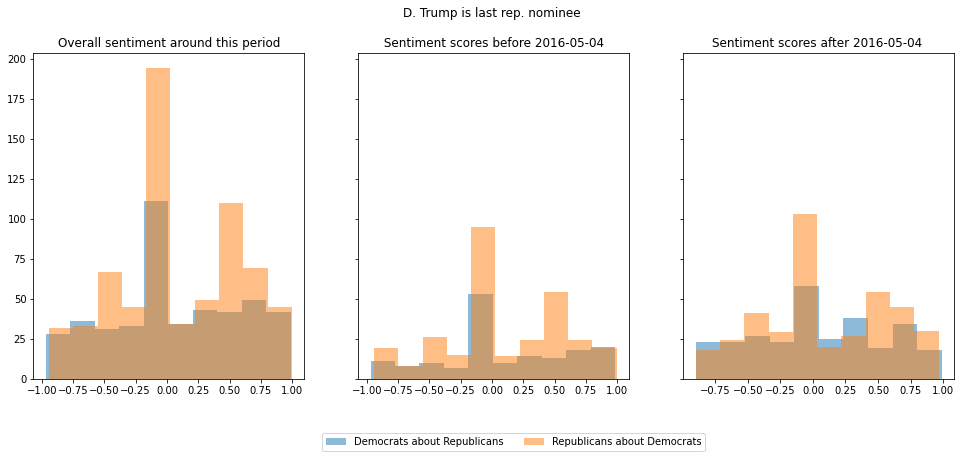

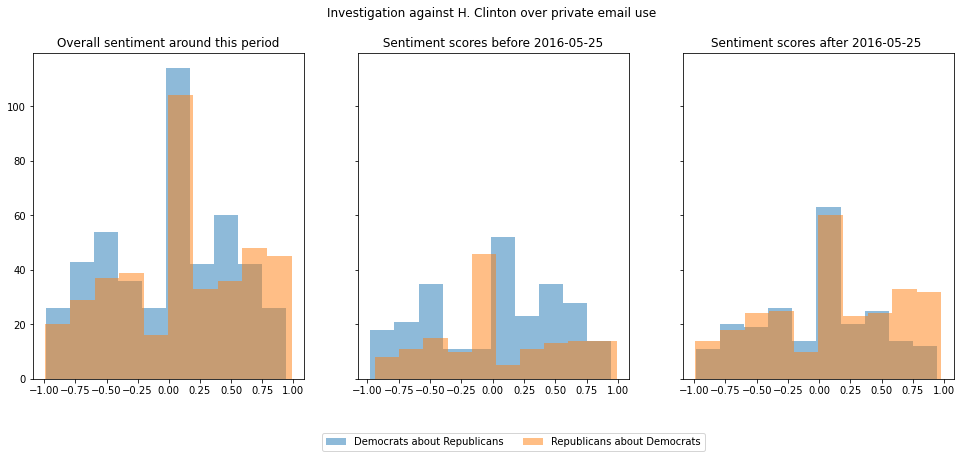

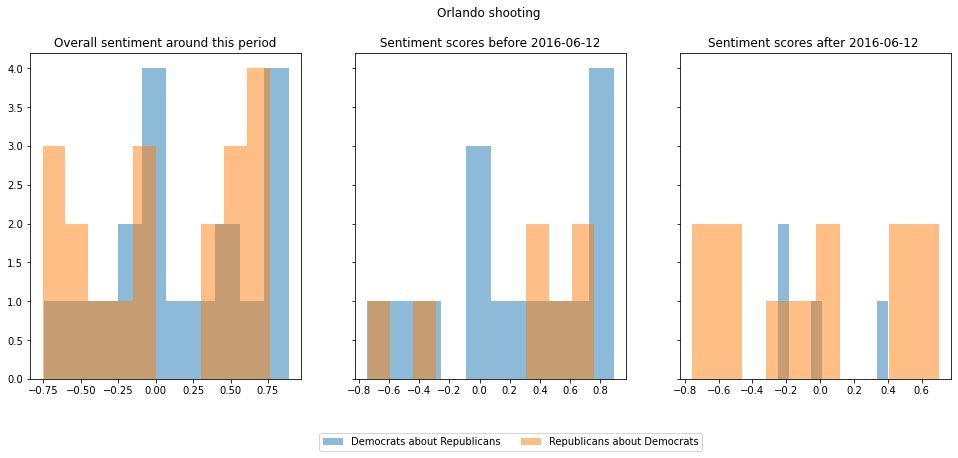

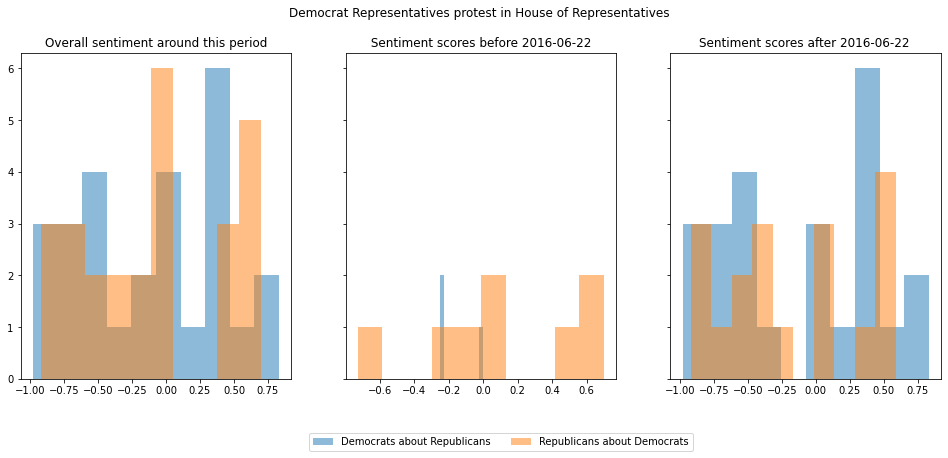

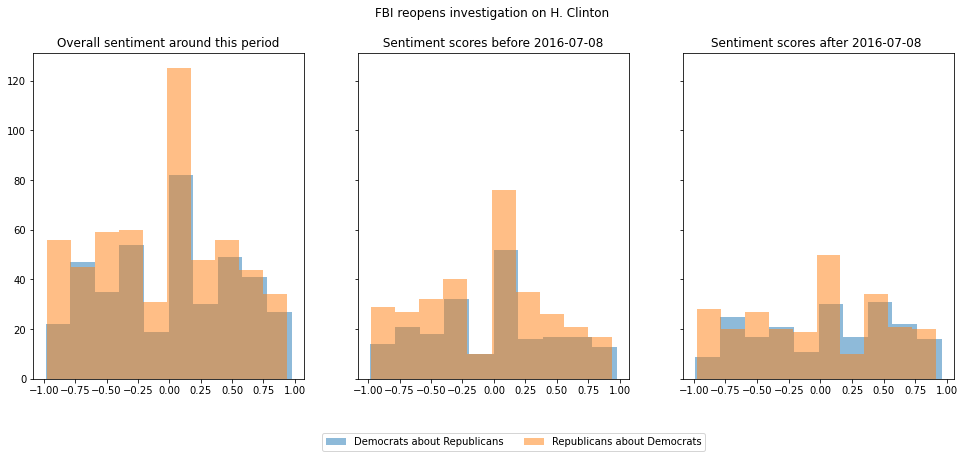

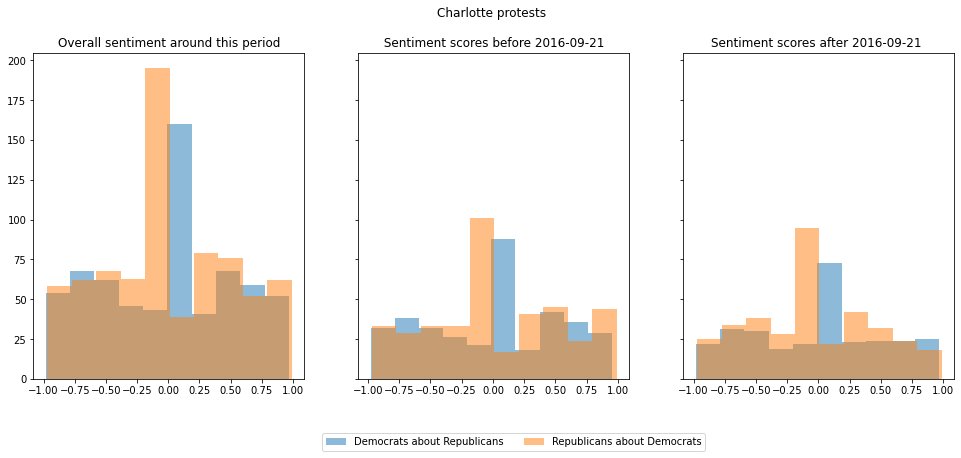

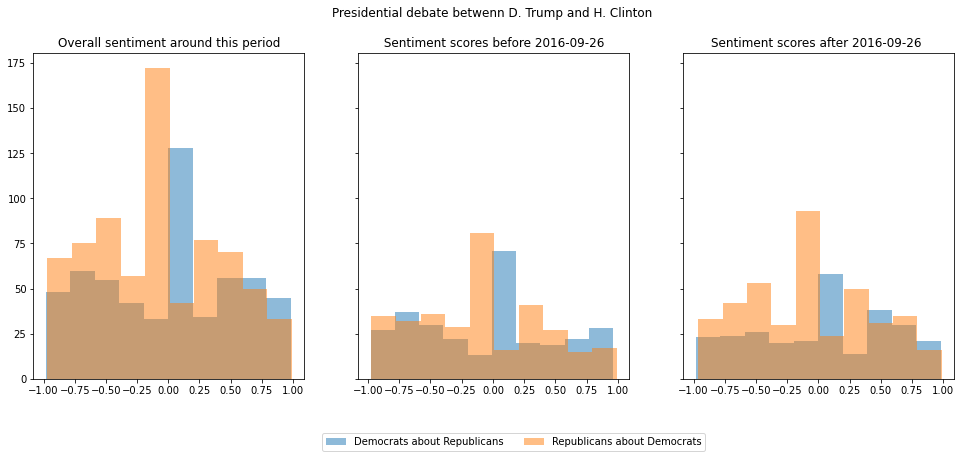

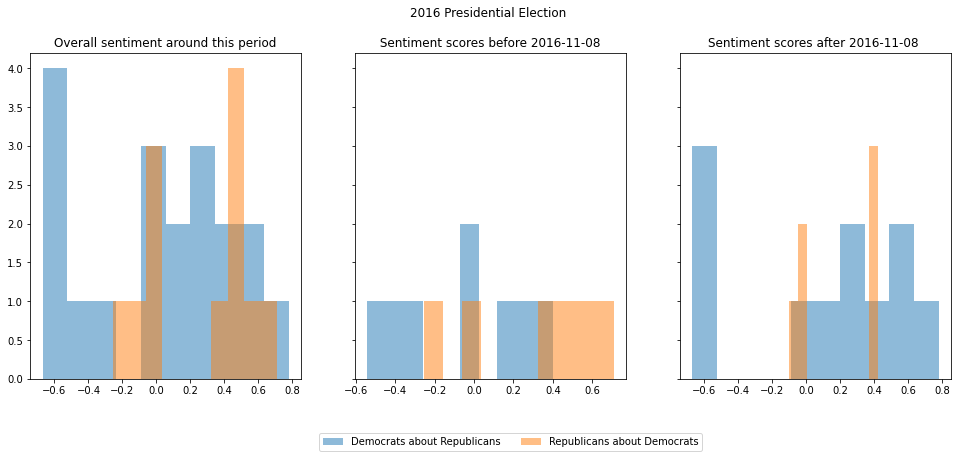

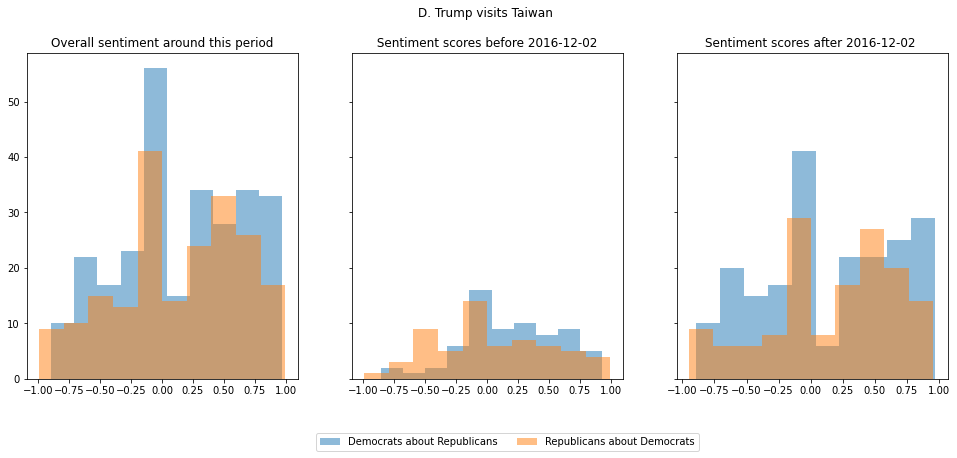

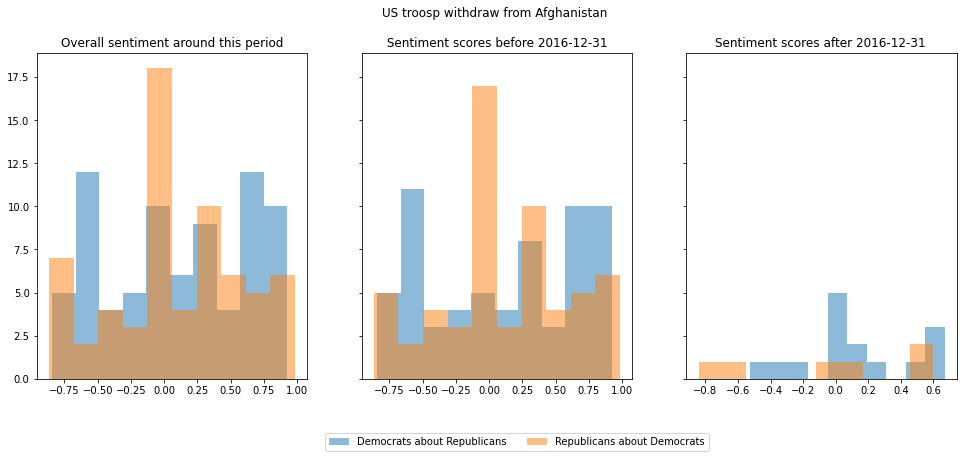

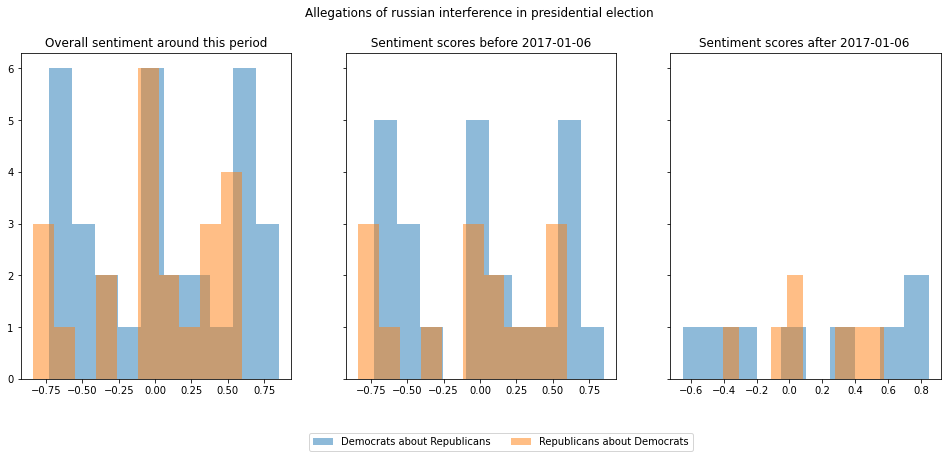

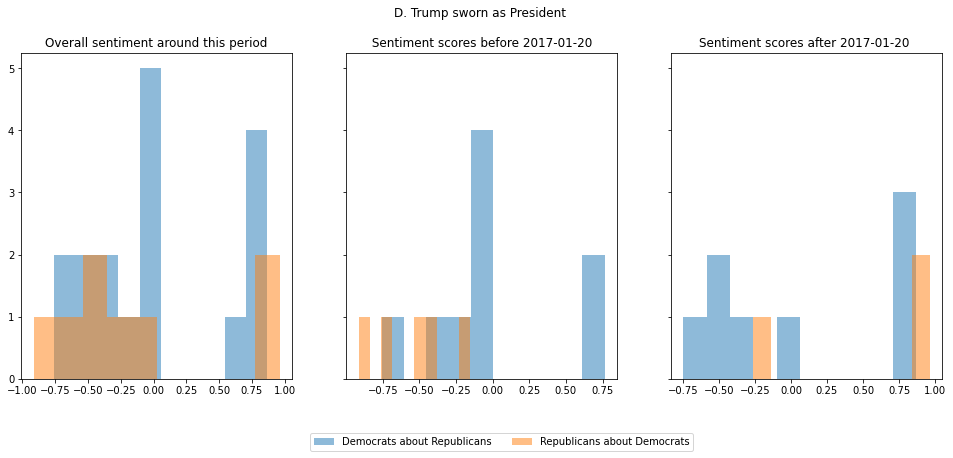

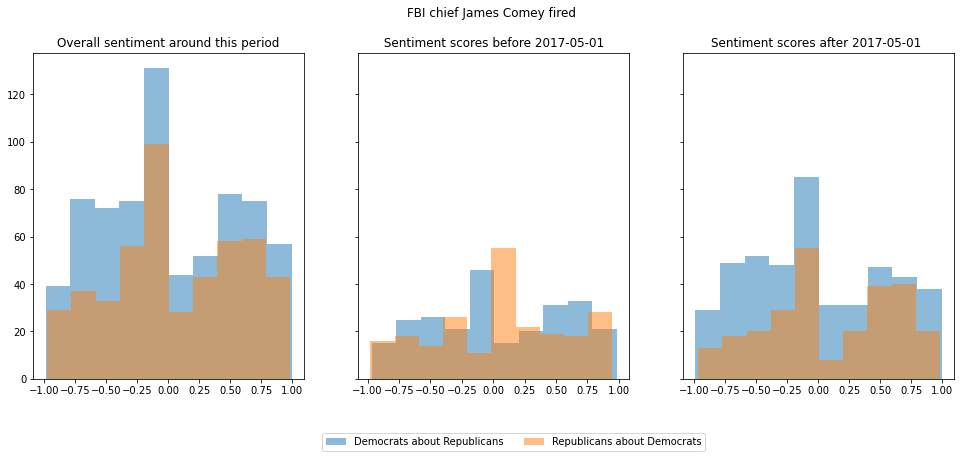

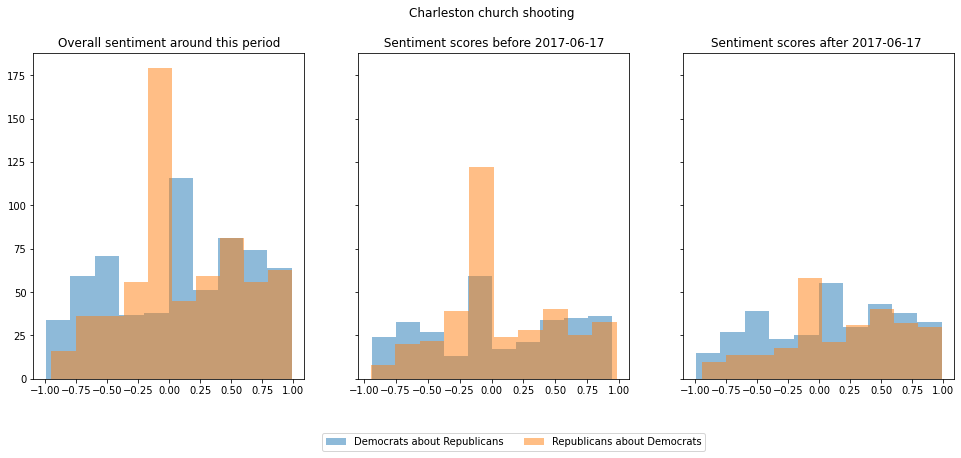

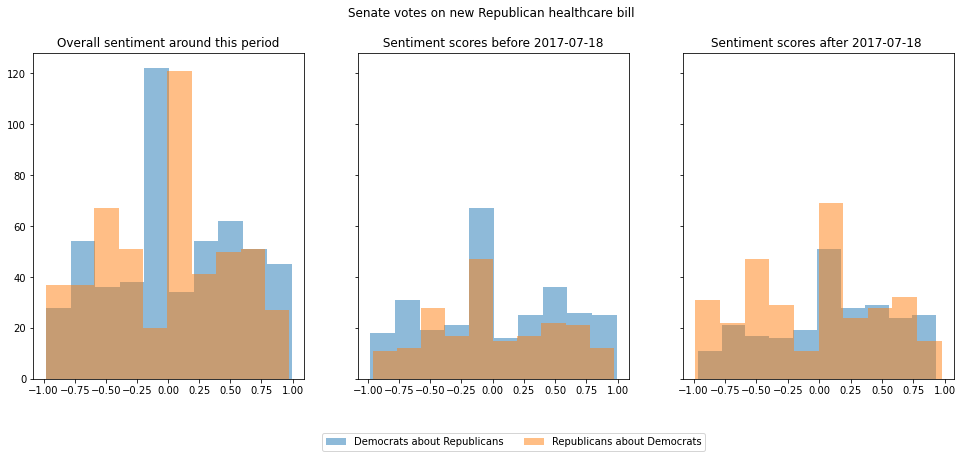

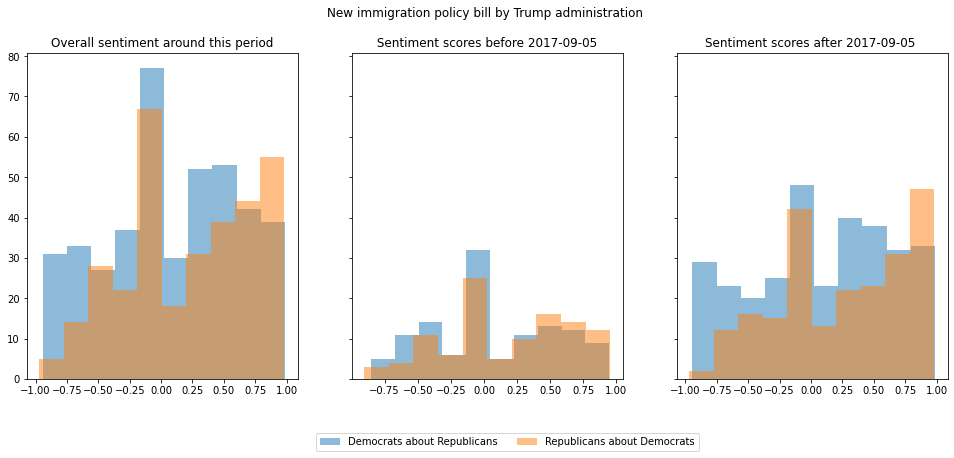

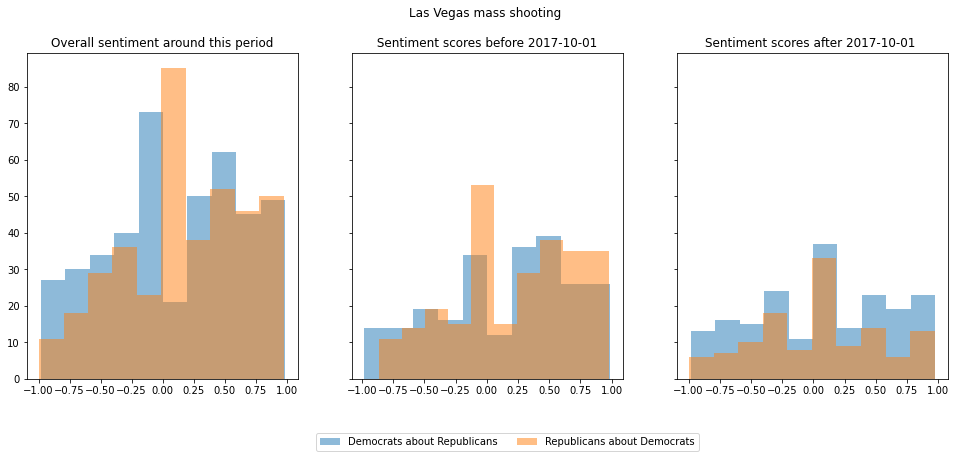

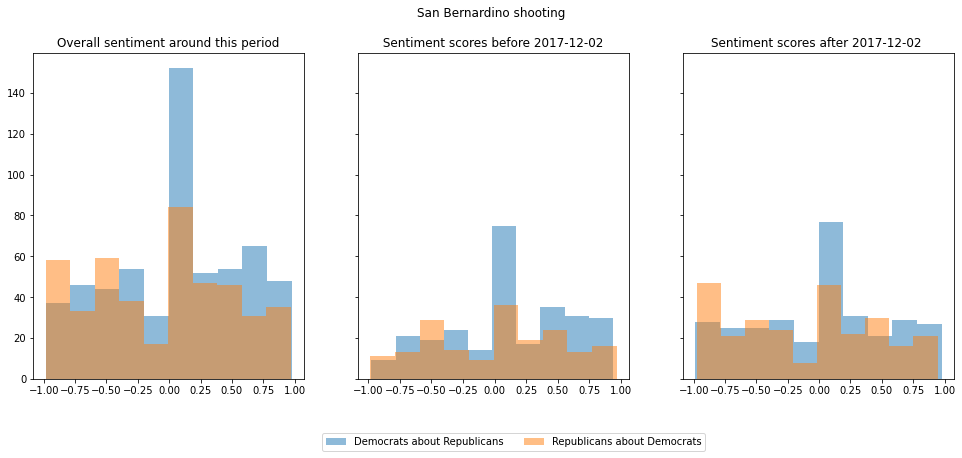

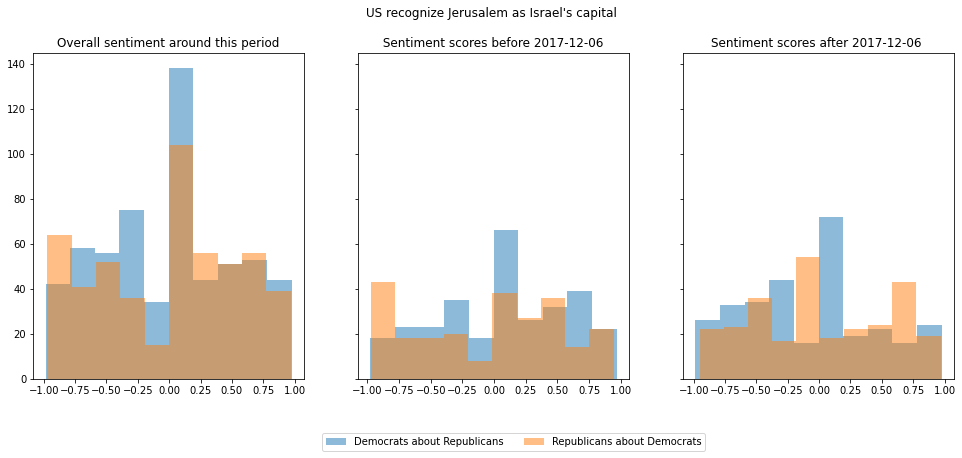

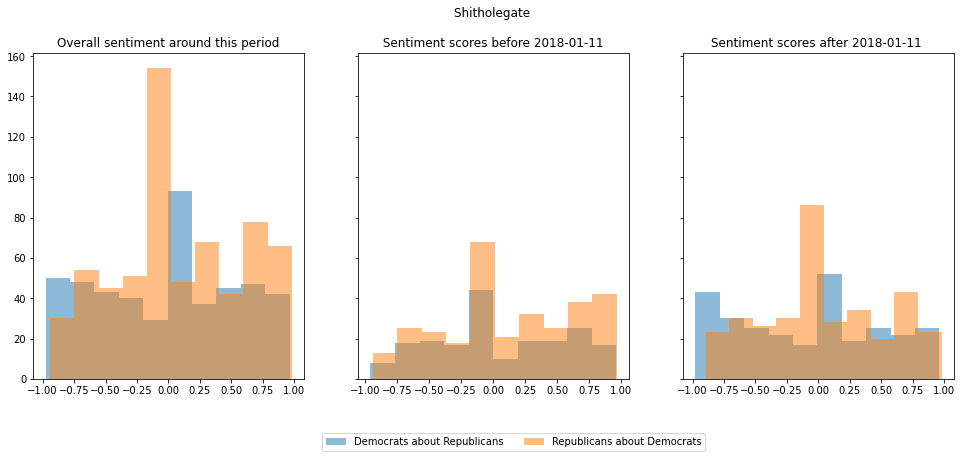

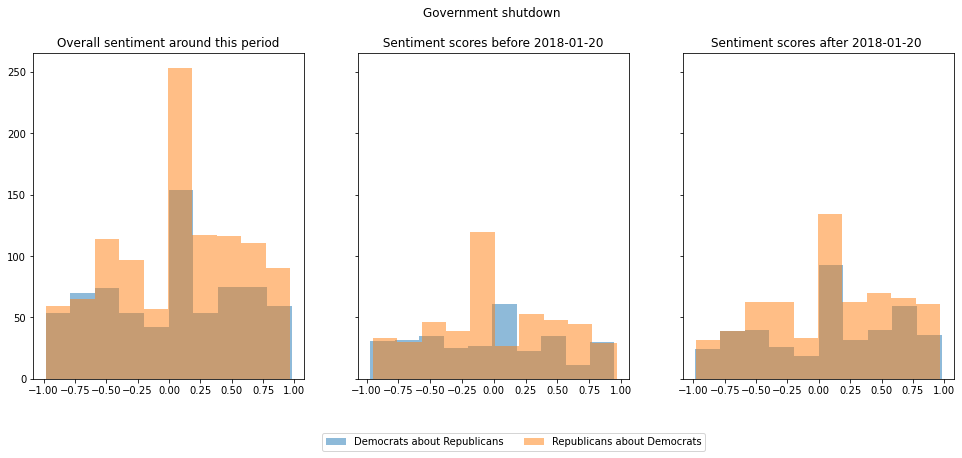

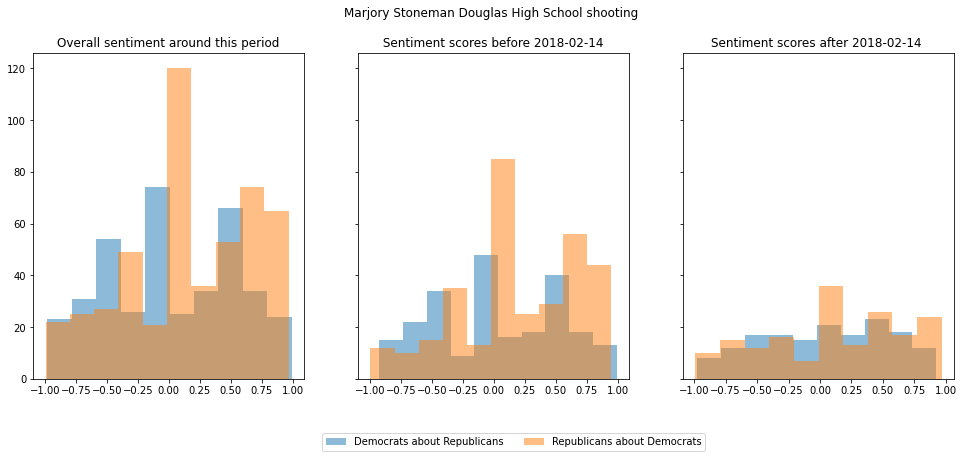

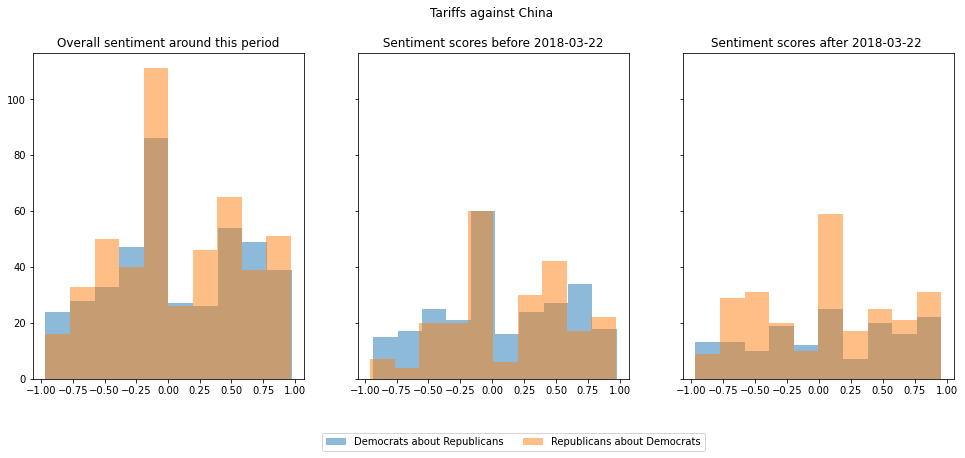

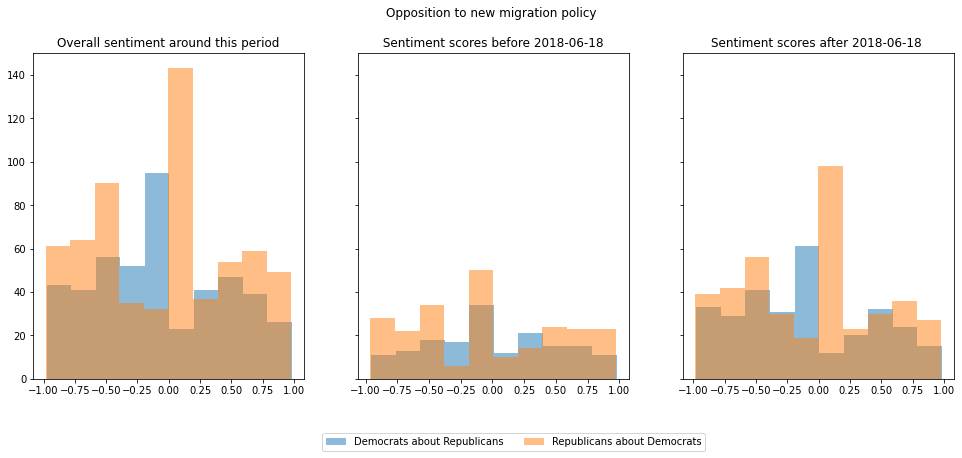

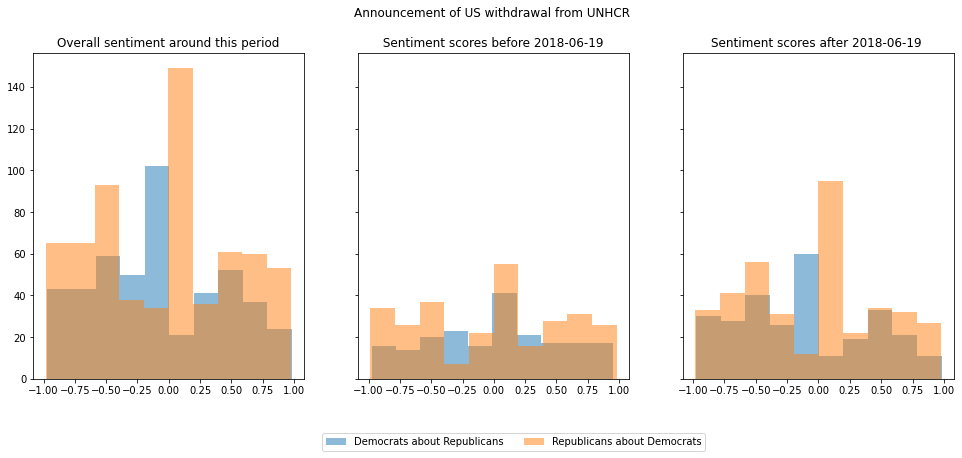

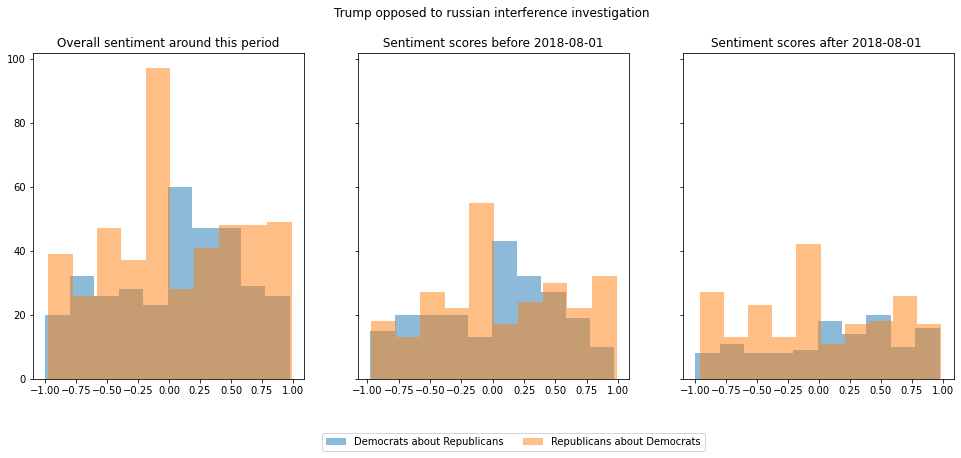

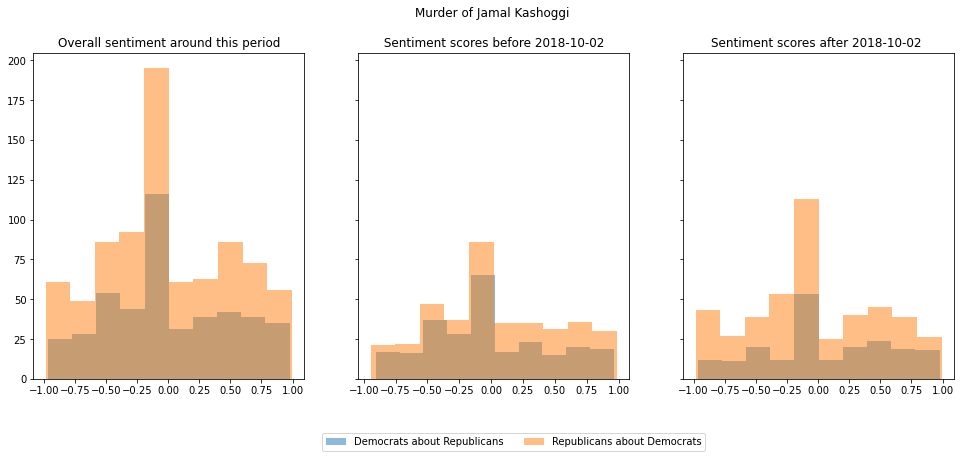

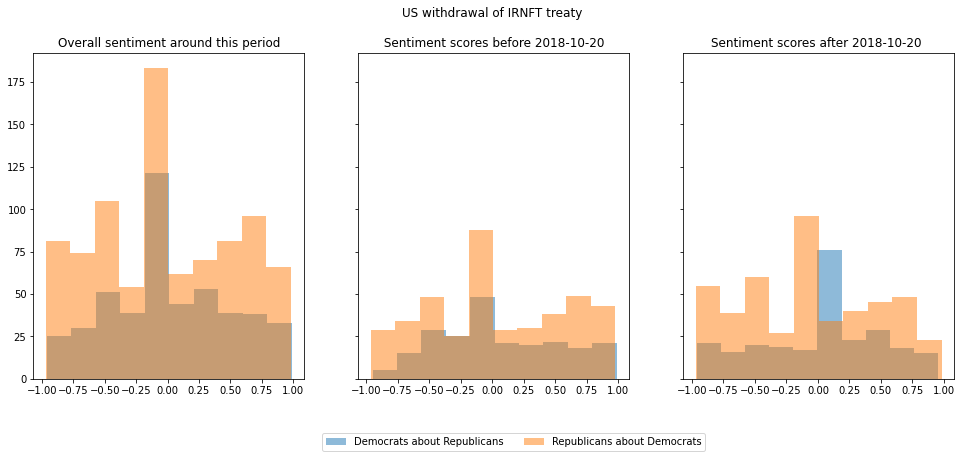

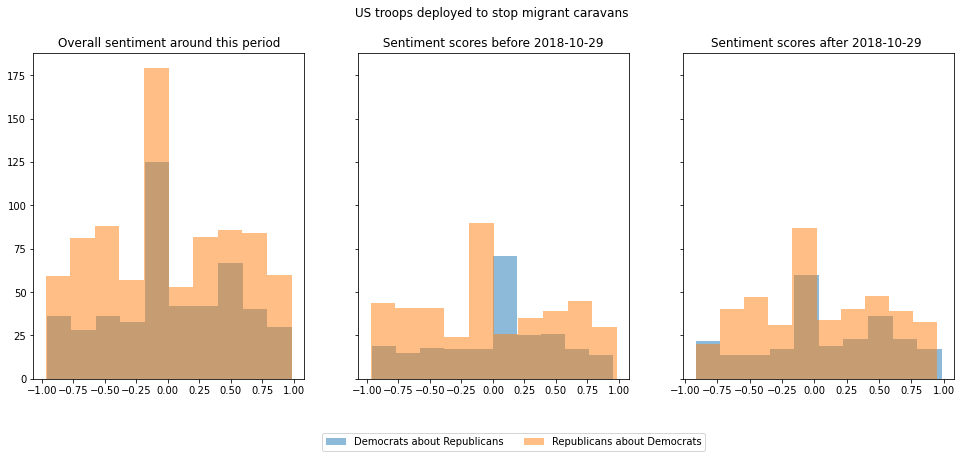

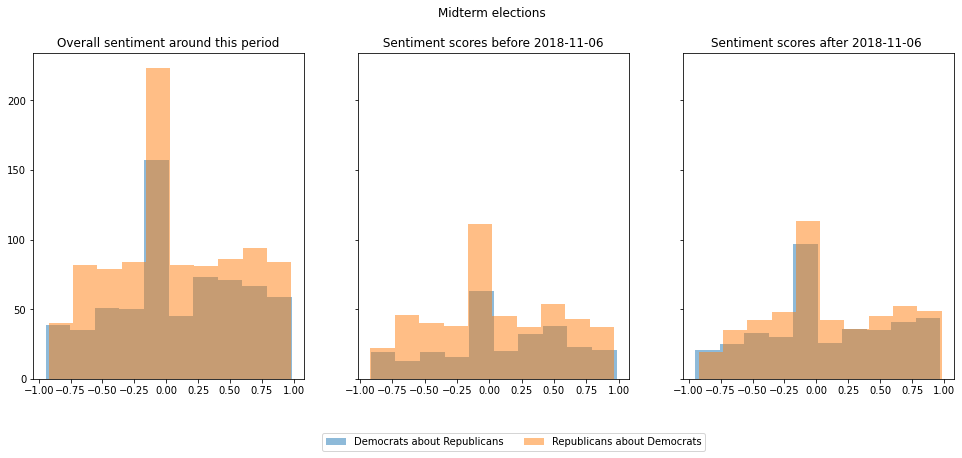

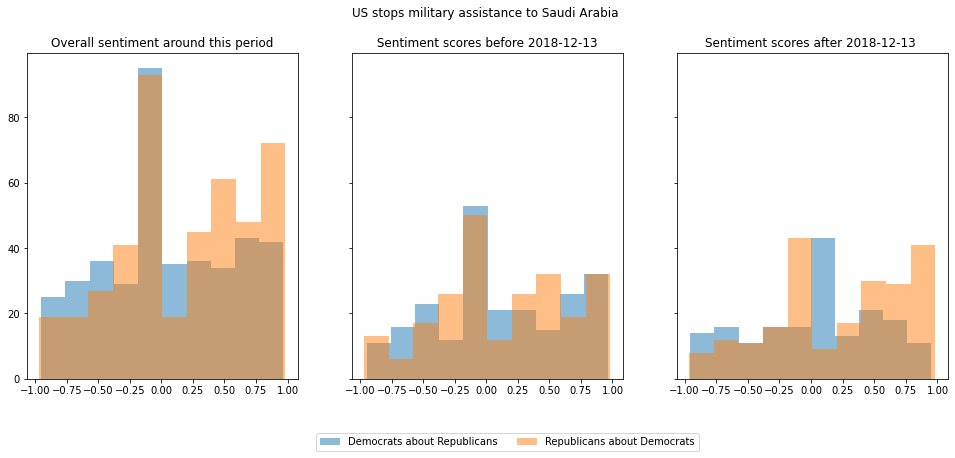

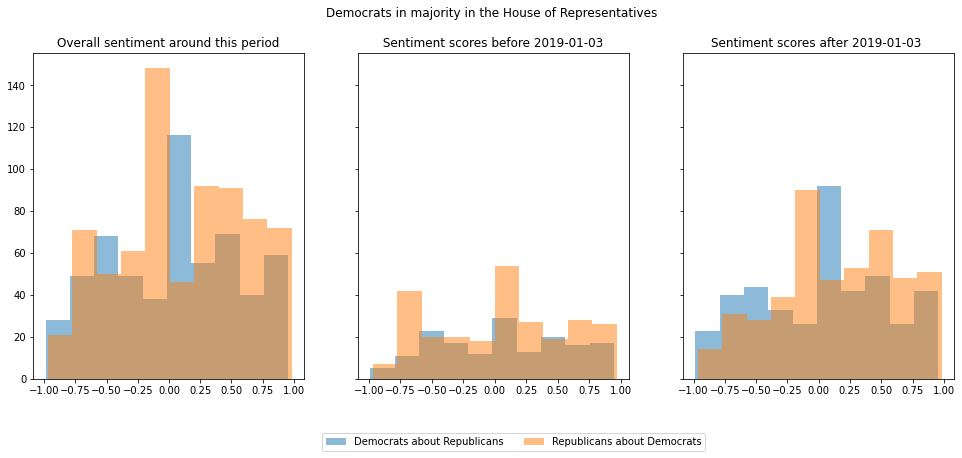

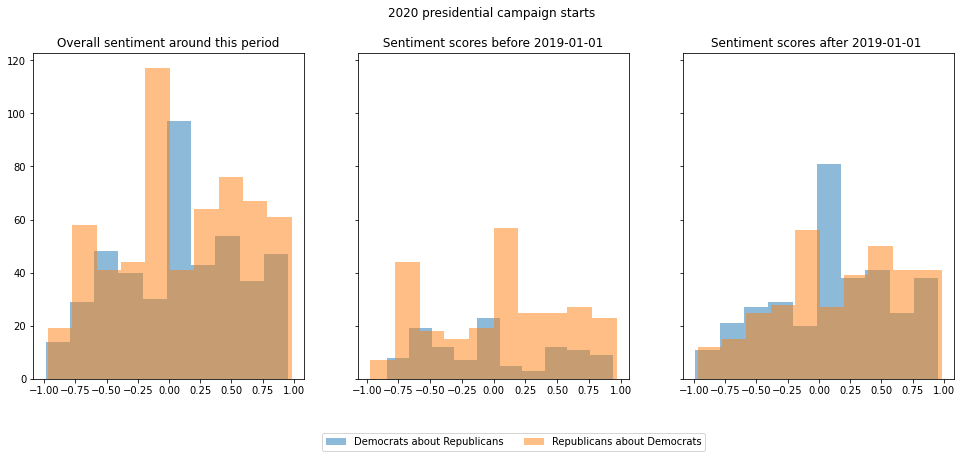

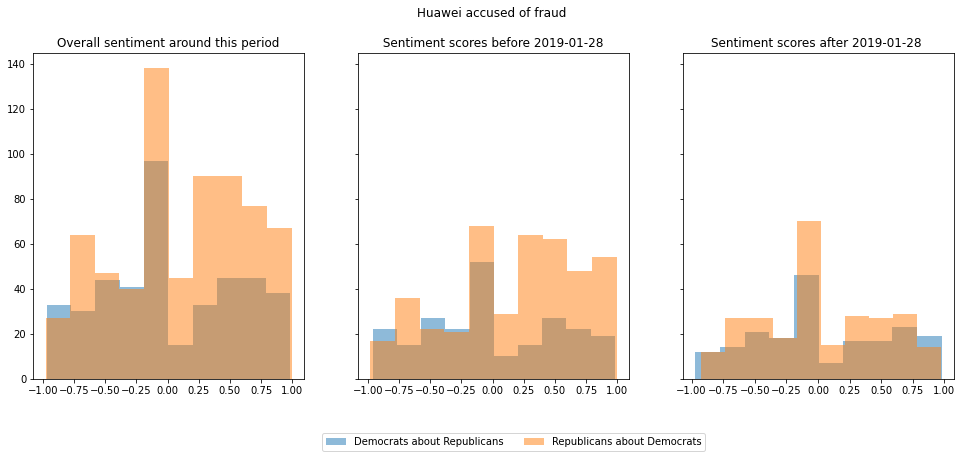

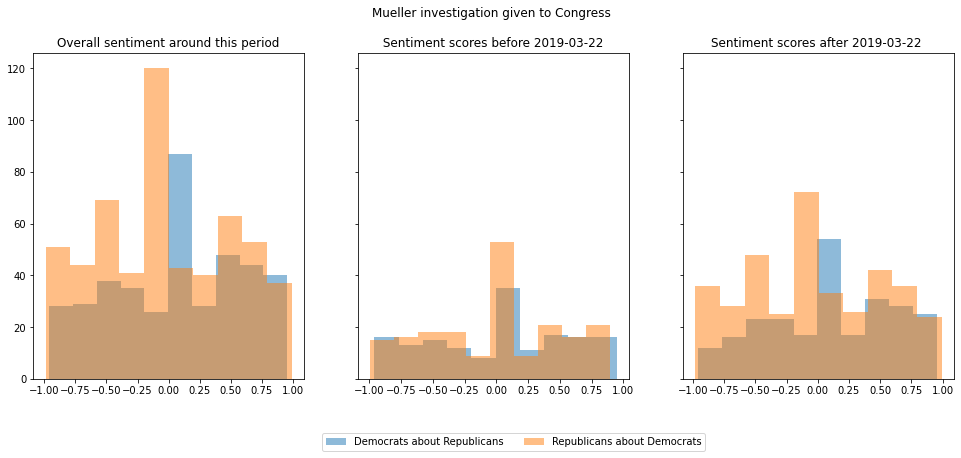

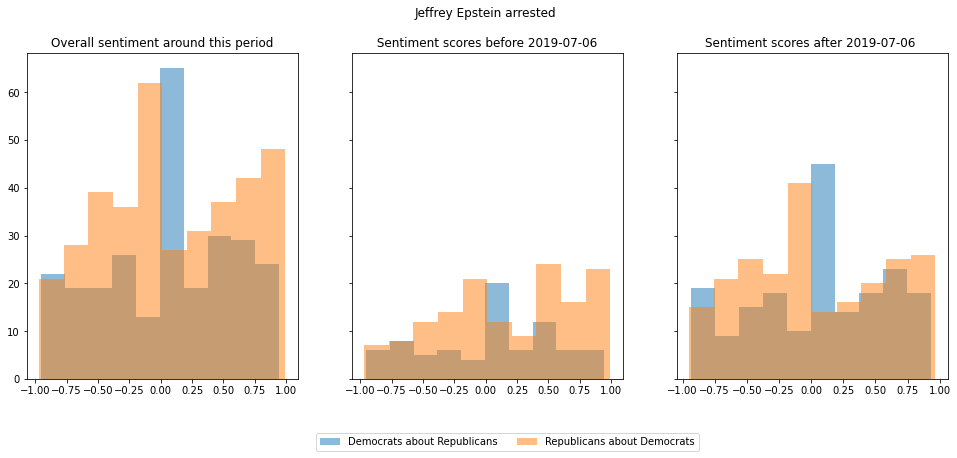

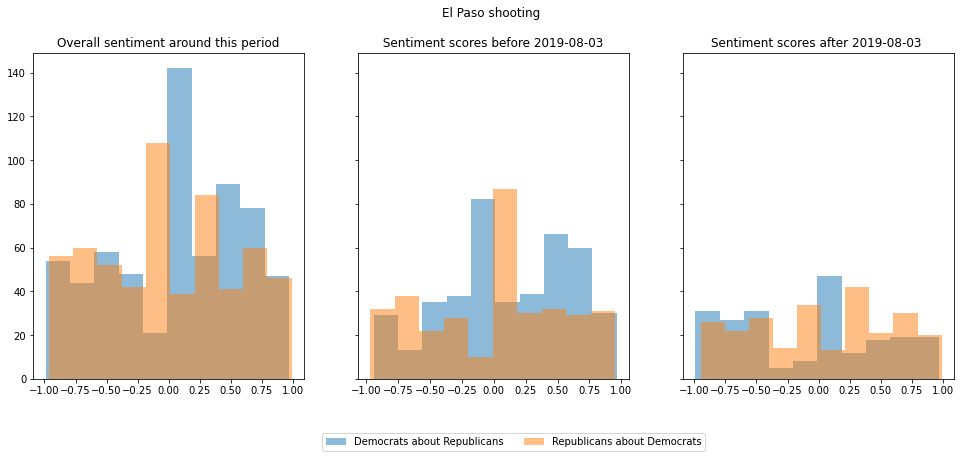

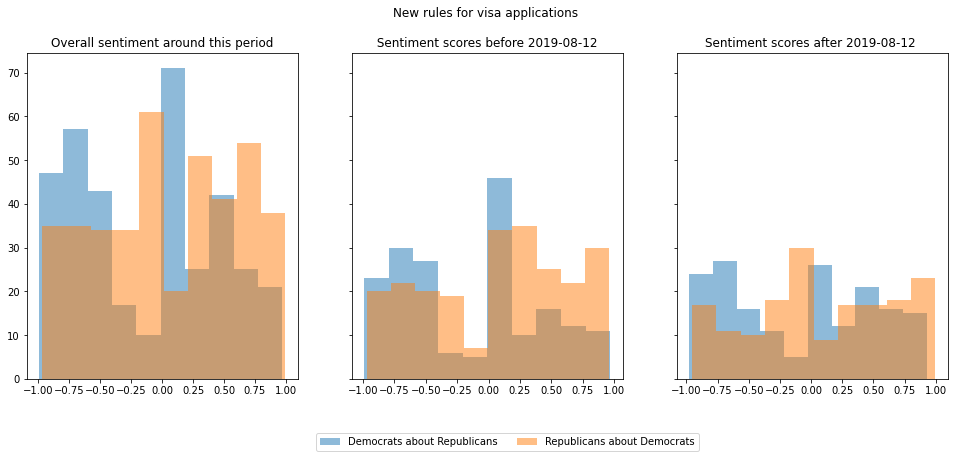

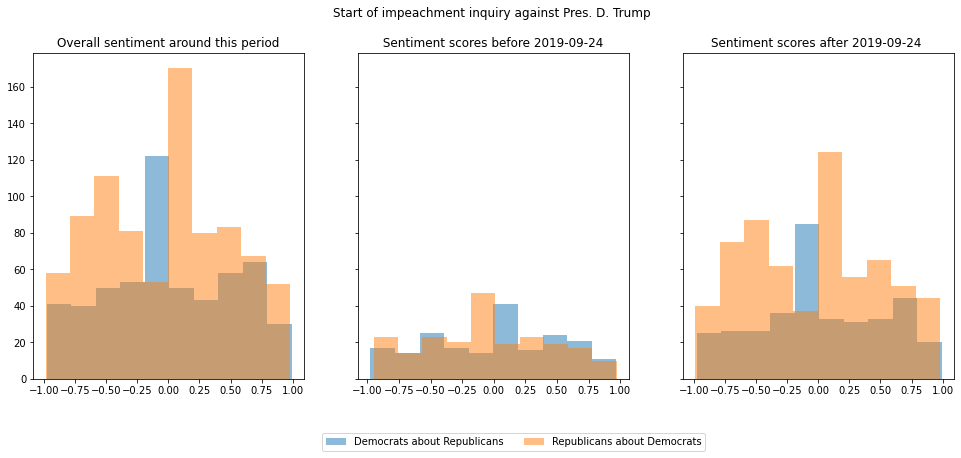

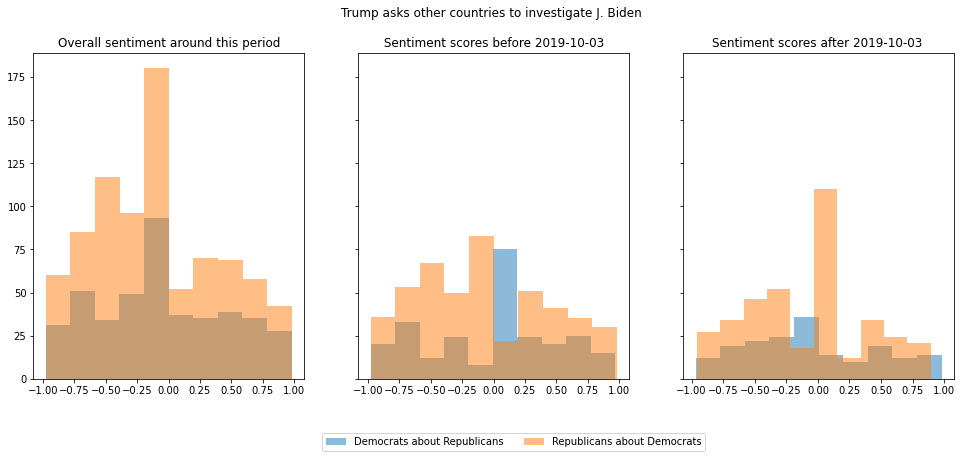

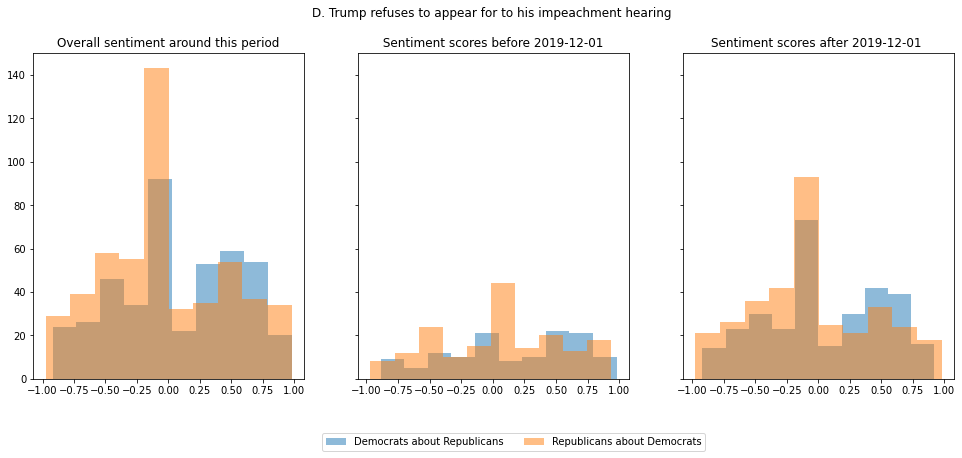

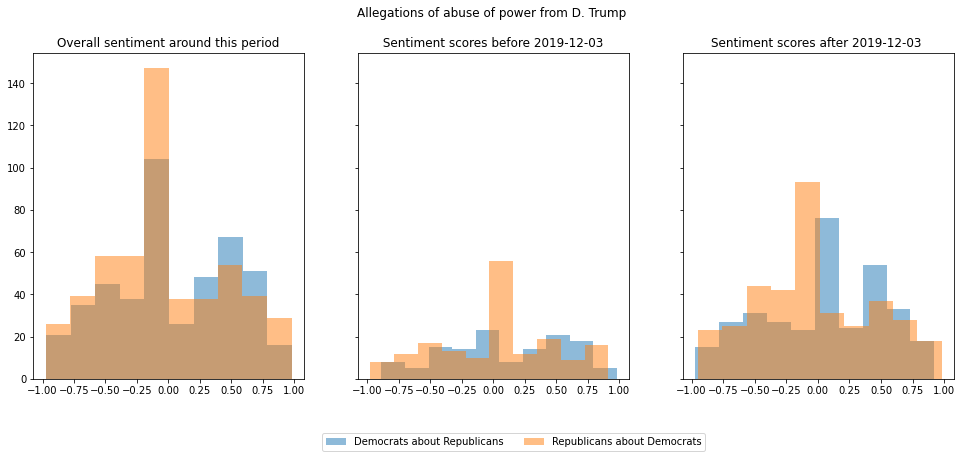

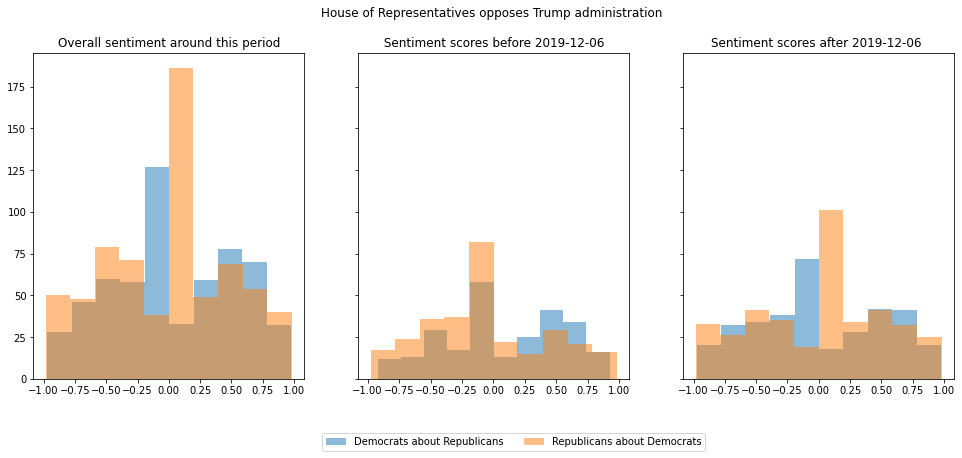

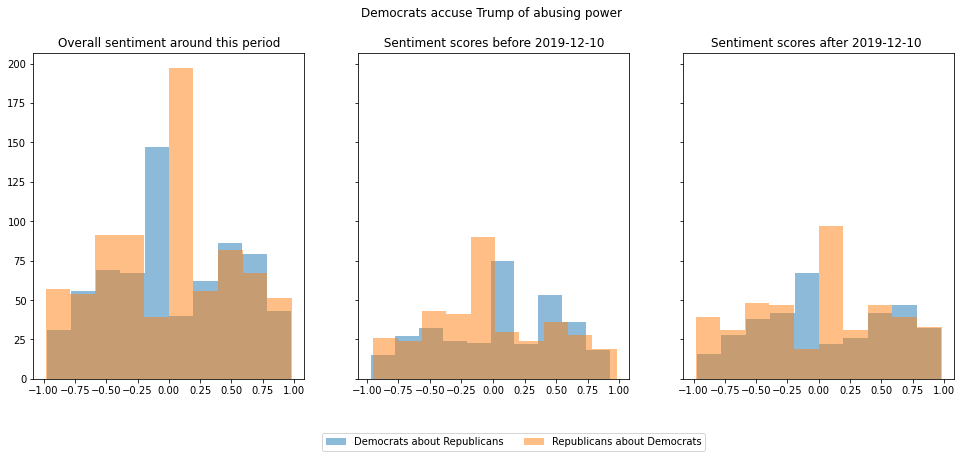

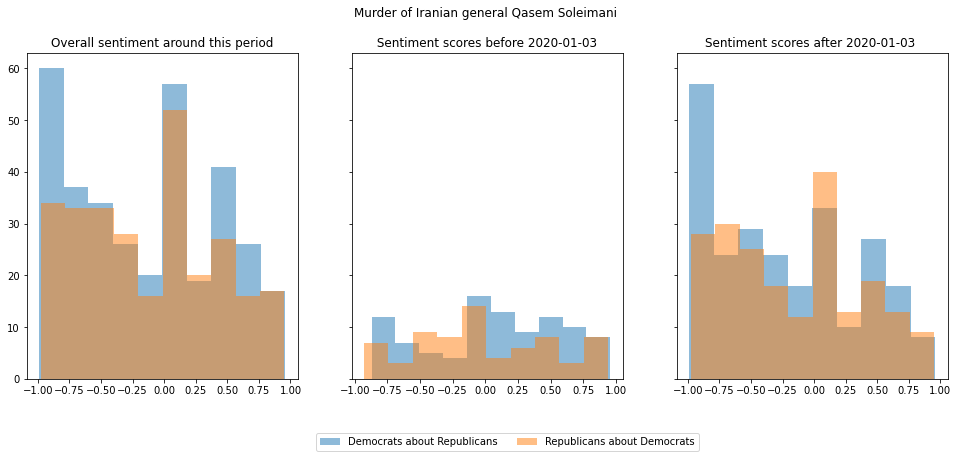

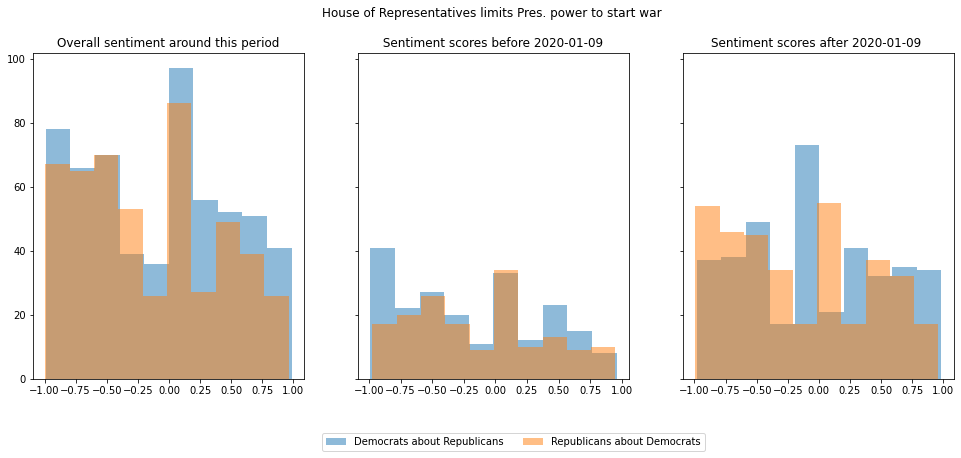

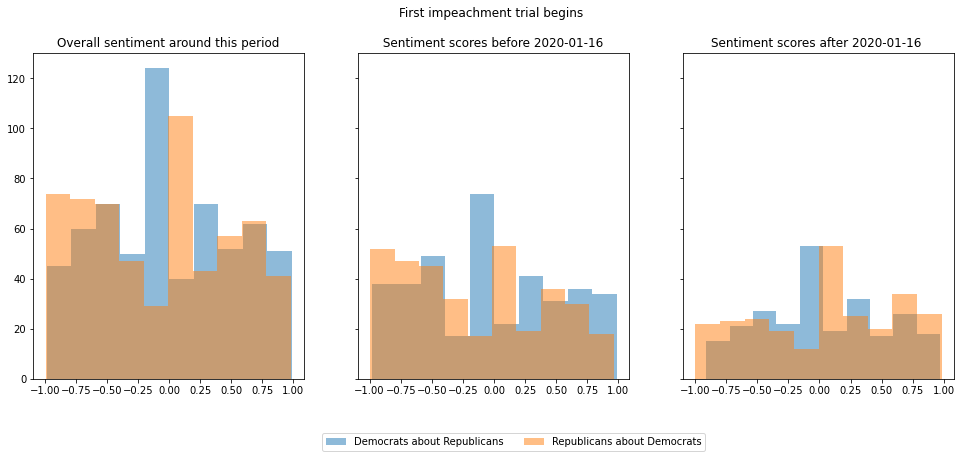

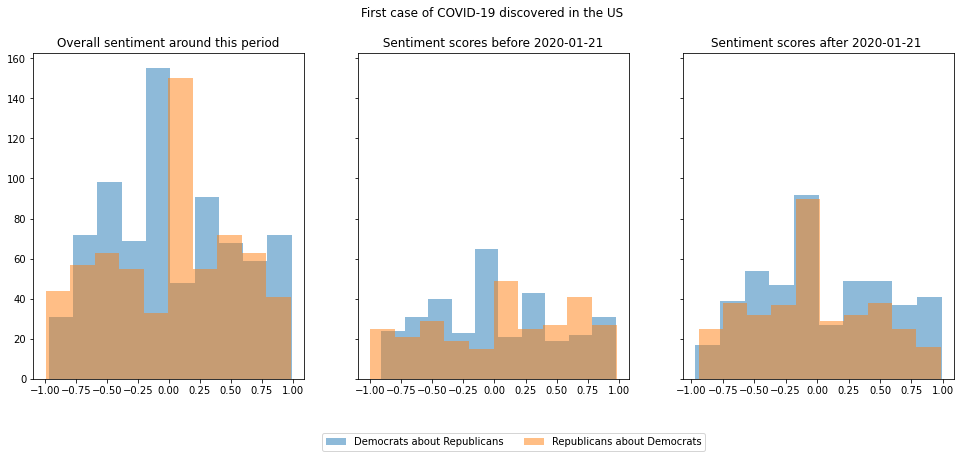

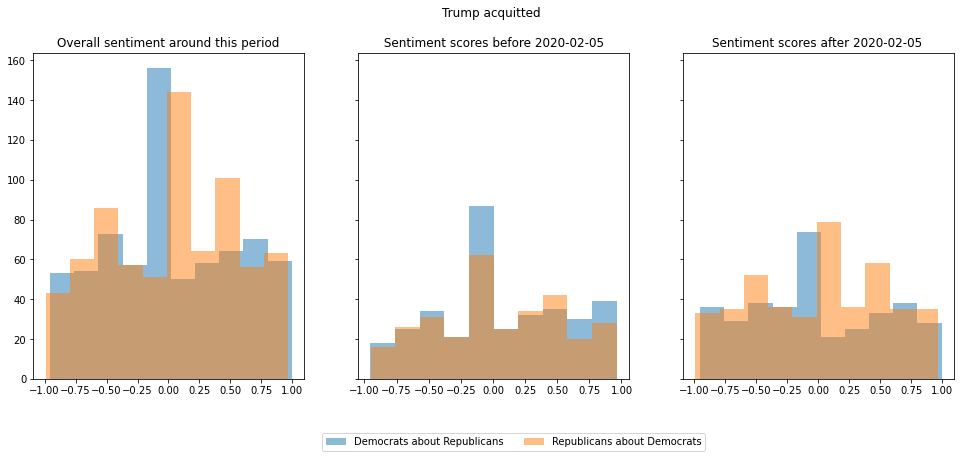

In [98]:
i = 0
for key_event in events.date:
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(16.5,6))
    axes[0].hist(df_dem[(df_dem['date'] < (key_event + timedelta(weeks=1))) & (df_dem['date'] > (key_event - timedelta(weeks=1)))]['compound'], alpha = 0.5, label ="Democrats about Republicans");
    axes[0].hist(df_rep[(df_rep['date'] < (key_event + timedelta(weeks=1))) & (df_rep['date'] > (key_event - timedelta(weeks=1)))]['compound'], alpha = 0.5, label ="Republicans about Democrats");
    axes[0].set_title('Overall sentiment around this period')
    axes[1].hist(df_dem[(df_dem['date'] > (key_event - timedelta(weeks=1))) & (df_dem['date'] <= key_event)]['compound'], alpha = 0.5, label ="Democrats about Republicans");
    axes[1].hist(df_rep[(df_rep['date'] > (key_event - timedelta(weeks=1))) & (df_rep['date'] <= key_event)]['compound'], alpha = 0.5, label ="Republicans about Democrats");
    axes[1].set_title('{} \n \n Sentiment scores before {} '.format(events[events['date'] == key_event]['short_desc'][i], key_event.date()))
    axes[2].hist(df_dem[(df_dem['date'] < (key_event + timedelta(weeks=1))) & (df_dem['date'] >= key_event)]['compound'], alpha = 0.5, label ="Democrats about Republicans");
    axes[2].hist(df_rep[(df_rep['date'] < (key_event + timedelta(weeks=1))) & (df_rep['date'] >= key_event)]['compound'], alpha = 0.5, label ="Republicans about Democrats");
    axes[2].set_title('Sentiment scores after {} '.format(key_event.date()))
    axes[0].legend(bbox_to_anchor =(2.5, -0.15), ncol = 2)
    i = i + 1

For each set of graphs, we computed a first distribution of the overall sentiment score a week around each key events, then the same distribution for each party (democrats then republicans).

#### Summary table of compound scores and number of quotes

To observe this data from another angle, we compute the averages of the scores and the number of quotes for each time period (week prior/after/overall) and for each party, to which we added a column of the difference in scores between the 2 time periods and another column for the relative evolution of number of quotes.

In [99]:
# Empty tables
cols = ['Event', 'Compound_avg', 'Compound_avg_bef', 'Compound_avg_aft', 'Diff_comp_avg', 'Quotes_num', 'Quotes_num_bef', 'Quotes_num_aft', 'Quotes_num_evol']
sum_all = pd.DataFrame(columns=cols, index=range(len(events.date)-3))
sum_rep = pd.DataFrame(columns=cols, index=range(len(events.date)-3))
sum_dem = pd.DataFrame(columns=cols, index=range(len(events.date)-3))

# Fill tables
i = 0
for key_event in events.date[0:58]:
    
    sum_all['Event'][i] = events[events['date'] == key_event]['short_desc'][i]
    sum_all['Compound_avg'][i] = df[(df['date'] <= (key_event + timedelta(weeks=1))) & (df['date'] > (key_event - timedelta(weeks=1)))]['compound'].mean()
    sum_all['Compound_avg_bef'][i] = df[(df['date'] >= (key_event - timedelta(weeks=1))) & (df['date'] <= key_event)]['compound'].mean()    
    sum_all['Compound_avg_aft'][i] = df[(df['date'] <= (key_event + timedelta(weeks=1))) & (df['date'] > key_event)]['compound'].mean()
    sum_all['Diff_comp_avg'][i] = sum_all['Compound_avg_aft'][i] - sum_all['Compound_avg_bef'][i]
    sum_all['Quotes_num'][i] = len(df[(df['date'] <= (key_event + timedelta(weeks=1))) & (df['date'] >= (key_event - timedelta(weeks=1)))]['compound'])
    sum_all['Quotes_num_bef'][i] = len(df[(df['date'] >= (key_event - timedelta(weeks=1))) & (df['date'] <= key_event)]['compound'])
    sum_all['Quotes_num_aft'][i] = len(df[(df['date'] <= (key_event + timedelta(weeks=1))) & (df['date'] > key_event)]['compound'])
    sum_all['Quotes_num_evol'][i] = (sum_all['Quotes_num_aft'][i] - sum_all['Quotes_num_bef'][i]) / sum_all['Quotes_num_bef'][i]
    
    sum_rep['Event'][i] = events[events['date'] == key_event]['short_desc'][i]
    sum_rep['Compound_avg'][i] = df_rep[(df_rep['date'] <= (key_event + timedelta(weeks=1))) & (df_rep['date'] > (key_event - timedelta(weeks=1)))]['compound'].mean()
    sum_rep['Compound_avg_bef'][i] = df_rep[(df_rep['date'] >= (key_event - timedelta(weeks=1))) & (df_rep['date'] <= key_event)]['compound'].mean()    
    sum_rep['Compound_avg_aft'][i] = df_rep[(df_rep['date'] <= (key_event + timedelta(weeks=1))) & (df_rep['date'] > key_event)]['compound'].mean()
    sum_rep['Diff_comp_avg'][i] = sum_rep['Compound_avg_aft'][i] - sum_rep['Compound_avg_bef'][i]
    sum_rep['Quotes_num'][i] = len(df_rep[(df_rep['date'] <= (key_event + timedelta(weeks=1))) & (df_rep['date'] >= (key_event - timedelta(weeks=1)))]['compound'])
    sum_rep['Quotes_num_bef'][i] = len(df_rep[(df_rep['date'] >= (key_event - timedelta(weeks=1))) & (df_rep['date'] <= key_event)]['compound'])
    sum_rep['Quotes_num_aft'][i] = len(df_rep[(df_rep['date'] <= (key_event + timedelta(weeks=1))) & (df_rep['date'] > key_event)]['compound'])
    sum_rep['Quotes_num_evol'][i] = (sum_rep['Quotes_num_aft'][i] - sum_rep['Quotes_num_bef'][i]) / sum_rep['Quotes_num_bef'][i]
    
    sum_dem['Event'][i] = events[events['date'] == key_event]['short_desc'][i]
    sum_dem['Compound_avg'][i] = df_dem[(df_dem['date'] <= (key_event + timedelta(weeks=1))) & (df_dem['date'] > (key_event - timedelta(weeks=1)))]['compound'].mean()
    sum_dem['Compound_avg_bef'][i] = df_dem[(df_dem['date'] >= (key_event - timedelta(weeks=1))) & (df_dem['date'] <= key_event)]['compound'].mean()    
    sum_dem['Compound_avg_aft'][i] = df_dem[(df_dem['date'] <= (key_event + timedelta(weeks=1))) & (df_dem['date'] > key_event)]['compound'].mean()
    sum_dem['Diff_comp_avg'][i] = sum_dem['Compound_avg_aft'][i] - sum_dem['Compound_avg_bef'][i]
    sum_dem['Quotes_num'][i] = len(df_dem[(df_dem['date'] <= (key_event + timedelta(weeks=1))) & (df_dem['date'] >= (key_event - timedelta(weeks=1)))]['compound'])
    sum_dem['Quotes_num_bef'][i] = len(df_dem[(df_dem['date'] >= (key_event - timedelta(weeks=1))) & (df_dem['date'] <= key_event)]['compound'])
    sum_dem['Quotes_num_aft'][i] = len(df_dem[(df_dem['date'] <= (key_event + timedelta(weeks=1))) & (df_dem['date'] > key_event)]['compound'])
    sum_dem['Quotes_num_evol'][i] = (sum_dem['Quotes_num_aft'][i] - sum_dem['Quotes_num_bef'][i]) / sum_dem['Quotes_num_bef'][i]
       
    i += 1

Here an example of the first 3 rows of the summary table for republicans :

In [100]:
sum_rep.head(3)

,Event,Compound_avg,Compound_avg_bef,Compound_avg_aft,Diff_comp_avg,Quotes_num,Quotes_num_bef,Quotes_num_aft,Quotes_num_evol
0,LGBT debate,0.156631,0.134371,0.190782,0.056411,185,112,73,-0.348214
1,US-Cuba relations start again,0.105433,0.064842,0.141698,0.076856,231,109,122,0.119266
2,2016 presidential campaign,0.194285,0.190782,0.198772,0.00799,130,73,57,-0.219178


We can then observe basic statistics of each newly created metrics :

In [101]:
sum_all.iloc[:,1:9].astype(float).describe()

,Compound_avg,Compound_avg_bef,Compound_avg_aft,Diff_comp_avg,Quotes_num,Quotes_num_bef,Quotes_num_aft,Quotes_num_evol
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,0.043751,0.052369,0.040659,-0.011710,837.482759,387.293103,450.189655,0.543237
std,0.073972,0.085765,0.085736,0.099909,477.252820,232.900250,276.851563,2.406682
min,-0.144072,-0.195814,-0.209481,-0.265601,19.000000,8.000000,5.000000,-0.969136
25%,-0.000446,0.002049,-0.015273,-0.069608,394.000000,163.750000,252.500000,-0.232143
50%,0.035882,0.047833,0.043577,0.002758,933.000000,425.500000,464.000000,0.111834
75%,0.096139,0.113943,0.094375,0.034095,1186.500000,549.250000,669.000000,0.710115
max,0.190695,0.299708,0.226973,0.362523,1797.000000,786.000000,1011.000000,17.750000


A first quick look at this table reveals that on average, there are more quotes citing the opposition after an event than before. However, the high deviations in this score between events in our dataset diminishes the value of this finding. <br>
We'll carry on with plots of the summary table to get a sense of the evolution of each metrics. <br>

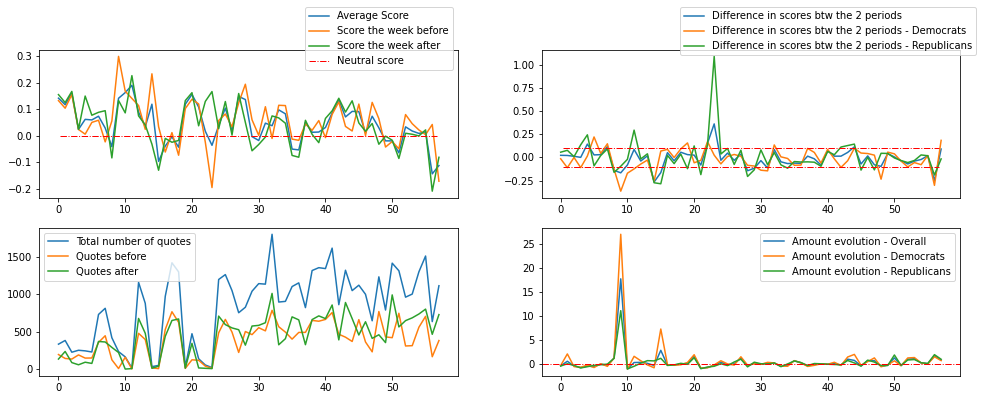

In [102]:
fig, axes = plt.subplots(2, 2, figsize=(16.5,6))
axes[0,0].plot(sum_all.iloc[:,1], label=('Average Score'))
axes[0,0].plot(sum_all.iloc[:,2], label=('Score the week before'))
axes[0,0].plot(sum_all.iloc[:,3], label=('Score the week after'))
axes[0,0].axhline(y=0, xmin=0.05, xmax=0.95, color='r', linestyle='-.', linewidth=1, label=('Neutral score'))
axes[0,0].legend(loc='best', bbox_to_anchor=(1, 1.32))
axes[0,1].plot(sum_all.iloc[:,4], label=('Difference in scores btw the 2 periods'))
axes[0,1].plot(sum_dem.iloc[:,4], label=('Difference in scores btw the 2 periods - Democrats'))
axes[0,1].plot(sum_rep.iloc[:,4], label=('Difference in scores btw the 2 periods - Republicans'))
axes[0,1].legend(loc='upper right', bbox_to_anchor=(1.05, 1.32))
axes[0,1].axhline(y=0.1, xmin=0.05, xmax=0.95, color='r', linestyle='-.', linewidth=1)
axes[0,1].axhline(y=-0.1, xmin=0.05, xmax=0.95, color='r', linestyle='-.', linewidth=1)
axes[1,0].plot(sum_all.iloc[:,5], label=('Total number of quotes'))
axes[1,0].plot(sum_all.iloc[:,6], label=('Quotes before'))
axes[1,0].plot(sum_all.iloc[:,7], label=('Quotes after'))
axes[1,0].legend()
axes[1,1].plot(sum_all.iloc[:,8], label=('Amount evolution - Overall'))
axes[1,1].plot(sum_dem.iloc[:,8], label=('Amount evolution - Democrats'))
axes[1,1].plot(sum_rep.iloc[:,8], label=('Amount evolution - Republicans'))
axes[1,1].axhline(y=0, color='r', linestyle='-.', linewidth=1)
axes[1,1].legend()

- The 1st graph shows the average score component for each event : overall, before and after it happens. Most points seem to sit just above the neutral score line but still closer to 0 than 1. In average, this NLP didn't capture overwhelming negativity in these quotes. <br>
- The 2nd graph displays the previous score difference between the 2 periods, for each party. Again, this difference score is well contained around 0, except for a specific event we'll look into right below.
- The 3rd plot presents the number of quotes overall, before and after each event. It looks like before the ~25th event this metric was going up and down randomly, not hesitating to go close to 0. However, after this event, there are no more instance of number of quotes being very low (close to 0). We can see that overall there's an increase in the number of quotes against the opposition party.
- The last plot exhibits the quote number evolution metric for each event with a big spike around the 9th event and a smaller one around the 15th one. We can remove these excessively high values and take a closer look at this plot below :

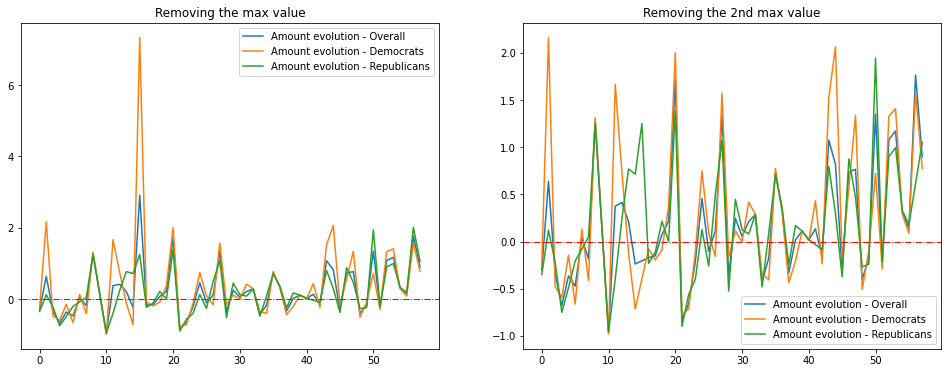

In [103]:
sum_all2 = sum_all.drop(index=sum_all[sum_all['Quotes_num_evol'] == sum_all['Quotes_num_evol'].max()].index)
sum_dem2 = sum_dem.drop(index=sum_dem[sum_dem['Quotes_num_evol'] == sum_dem['Quotes_num_evol'].max()].index)
sum_rep2 = sum_rep.drop(index=sum_rep[sum_rep['Quotes_num_evol'] == sum_rep['Quotes_num_evol'].max()].index)
sum_all3 = sum_all2.drop(index=sum_all2[sum_all2['Quotes_num_evol'] == sum_all2['Quotes_num_evol'].max()].index)
sum_dem3 = sum_dem2.drop(index=sum_dem2[sum_dem2['Quotes_num_evol'] == sum_dem2['Quotes_num_evol'].max()].index)
sum_rep3 = sum_rep2.drop(index=sum_rep2[sum_rep2['Quotes_num_evol'] == sum_rep2['Quotes_num_evol'].max()].index)
fig, axes = plt.subplots(1, 2, figsize=(16.5,6))
axes[0].plot(sum_all2.iloc[:,8], label=('Amount evolution - Overall'))
axes[0].plot(sum_dem2.iloc[:,8], label=('Amount evolution - Democrats'))
axes[0].plot(sum_rep2.iloc[:,8], label=('Amount evolution - Republicans'))
axes[0].axhline(y=0, color='r', linestyle='-.', linewidth=1)
axes[0].legend()
axes[0].set_title('Removing the max value');
axes[1].plot(sum_all3.iloc[:,8], label=('Amount evolution - Overall'))
axes[1].plot(sum_dem3.iloc[:,8], label=('Amount evolution - Democrats'))
axes[1].plot(sum_rep3.iloc[:,8], label=('Amount evolution - Republicans'))
axes[1].axhline(y=0, color='r', linestyle='-.', linewidth=1)
axes[1].legend()
axes[1].set_title('Removing the 2nd max value');

After removing these 2 extreme values, we can observe what may be a slightly increasing trend. This metric fluctuates a lot around 0 but it seems that it is a bit more often on the positive side, and when it gets to that side, the order of magnitude goes higher too. This underlines the fact we observe reactions towards events. When an event occur, there is often an undeniable reaction from politics towards their antagonist. <br>
The following 2 events were the one, relatively, most polemical :

In [104]:
sum_all[sum_all['Quotes_num_evol'] == sum_all['Quotes_num_evol'].max()]

,Event,Compound_avg,Compound_avg_bef,Compound_avg_aft,Diff_comp_avg,Quotes_num,Quotes_num_bef,Quotes_num_aft,Quotes_num_evol
9,New Hampshire primaries won by D. Trump,0.141425,0.299708,0.132984,-0.166725,237,12,225,17.75


In [105]:
sum_all2[sum_all2['Quotes_num_evol'] == sum_all2['Quotes_num_evol'].max()]

,Event,Compound_avg,Compound_avg_bef,Compound_avg_aft,Diff_comp_avg,Quotes_num,Quotes_num_bef,Quotes_num_aft,Quotes_num_evol
15,Democrat Representatives protest in House of R...,-0.097,0.033955,-0.1305,-0.164455,54,11,43,2.909091


It appears the average sentiment score of quotes after the event also quite decreased for both of them : around -0.16 point. These events induced a strong conflicting reaction.

#### Most extreme values inspection
##### Difference in score (average after - average before)
Overall

In [106]:
sum_all[(sum_all.iloc[:,4] >= sum_all.iloc[:,4].quantile(0.9)) | (sum_all.iloc[:,4] <= sum_all.iloc[:,4].quantile(0.1))].iloc[:,[0,4,6,7,8]]

,Event,Diff_comp_avg,Quotes_num_bef,Quotes_num_aft,Quotes_num_evol
4,H. Clinton email's controversy,0.144023,151,96,-0.364238
7,Paul Ryan (rep.) elected Speaker of the House ...,0.117798,448,365,-0.185268
8,San Bernardino shooting,-0.13973,128,293,1.289062
9,New Hampshire primaries won by D. Trump,-0.166725,12,225,17.75
14,Orlando shooting,-0.265601,21,16,-0.238095
15,Democrat Representatives protest in House of R...,-0.164455,11,43,2.909091
22,Allegations of russian interference in preside...,0.154115,44,15,-0.659091
23,D. Trump sworn as President,0.362523,14,11,-0.214286
28,Las Vegas mass shooting,-0.144179,504,323,-0.359127
44,2020 presidential campaign starts,0.113974,372,676,0.817204


Democrats

In [107]:
sum_dem[(sum_dem.iloc[:,4] >= sum_dem.iloc[:,4].quantile(0.9)) | (sum_dem.iloc[:,4] <= sum_dem.iloc[:,4].quantile(0.1))].iloc[:,[0,4,6,7,8]]

,Event,Diff_comp_avg,Quotes_num_bef,Quotes_num_aft,Quotes_num_evol
5,Same-sex marriage supreme court rule,0.221311,89,30,-0.662921
7,Paul Ryan (rep.) elected Speaker of the House ...,0.14728,228,134,-0.412281
9,New Hampshire primaries won by D. Trump,-0.364948,5,140,27.0
10,Super Tuesday,-0.170734,98,2,-0.979592
14,Orlando shooting,-0.255346,14,4,-0.714286
19,2016 Presidential Election,0.156594,8,11,0.375
22,Allegations of russian interference in preside...,0.170239,28,8,-0.714286
31,Shitholegate,-0.145314,199,282,0.417085
32,Government shutdown,0.134917,312,402,0.288462
48,El Paso shooting,-0.235365,428,211,-0.507009


Republicans

In [108]:
sum_rep[(sum_rep.iloc[:,4] >= sum_rep.iloc[:,4].quantile(0.9)) | (sum_rep.iloc[:,4] <= sum_rep.iloc[:,4].quantile(0.1))].iloc[:,[0,4,6,7,8]]

,Event,Diff_comp_avg,Quotes_num_bef,Quotes_num_aft,Quotes_num_evol
3,Baltimore protests,0.136596,104,26,-0.75
4,H. Clinton email's controversy,0.244324,96,49,-0.489583
8,San Bernardino shooting,-0.161446,44,99,1.25
11,Merrick Garland Supreme Court nomination,0.295073,5,3,-0.4
14,Orlando shooting,-0.274046,7,12,0.714286
15,Democrat Representatives protest in House of R...,-0.28526,8,18,1.25
21,US troosp withdraw from Afghanistan,-0.186107,59,6,-0.898305
22,Allegations of russian interference in preside...,0.136489,16,7,-0.5625
23,D. Trump sworn as President,1.092767,5,3,-0.4
28,Las Vegas mass shooting,-0.206088,268,127,-0.526119


Common events

In [109]:
sum_dif_all = sum_all[(sum_all.iloc[:,4] >= sum_all.iloc[:,4].quantile(0.9)) | (sum_all.iloc[:,4] <= sum_all.iloc[:,4].quantile(0.1))].index
sum_dif_dem = sum_dem[(sum_dem.iloc[:,4] >= sum_dem.iloc[:,4].quantile(0.9)) | (sum_dem.iloc[:,4] <= sum_dem.iloc[:,4].quantile(0.1))].index
sum_dif_rep = sum_rep[(sum_rep.iloc[:,4] >= sum_rep.iloc[:,4].quantile(0.9)) | (sum_rep.iloc[:,4] <= sum_rep.iloc[:,4].quantile(0.1))].index
common = list(set(sum_dif_all).intersection(sum_dif_dem).intersection(sum_dif_rep))
sum_all.iloc[common,:].iloc[:,[0,4,6,7,8]]

,Event,Diff_comp_avg,Quotes_num_bef,Quotes_num_aft,Quotes_num_evol
56,Murder of Iranian general Qasem Soleimani,-0.251909,169,467,1.763314
14,Orlando shooting,-0.265601,21,16,-0.238095
22,Allegations of russian interference in preside...,0.154115,44,15,-0.659091


In [110]:
sum_dem.iloc[common,:].iloc[:,[0,4,6,7,8]]

,Event,Diff_comp_avg,Quotes_num_bef,Quotes_num_aft,Quotes_num_evol
56,Murder of Iranian general Qasem Soleimani,-0.302334,96,247,1.572917
14,Orlando shooting,-0.255346,14,4,-0.714286
22,Allegations of russian interference in preside...,0.170239,28,8,-0.714286


In [111]:
sum_rep.iloc[common,:].iloc[:,[0,4,6,7,8]]

,Event,Diff_comp_avg,Quotes_num_bef,Quotes_num_aft,Quotes_num_evol
56,Murder of Iranian general Qasem Soleimani,-0.19001,73,220,2.013699
14,Orlando shooting,-0.274046,7,12,0.714286
22,Allegations of russian interference in preside...,0.136489,16,7,-0.5625


##### Most controversial events (increase in number of quotes the week after)

Here we list the events that were the 20% most controversial, in terms of percentage of increase in the number of quotes from the day an event happened.

Overall

In [112]:
sum_all[(sum_all.iloc[:,8] >= sum_all.iloc[:,8].quantile(0.8))].iloc[:,[0,4,6,7,8]]

,Event,Diff_comp_avg,Quotes_num_bef,Quotes_num_aft,Quotes_num_evol
8,San Bernardino shooting,-0.13973,128,293,1.289062
9,New Hampshire primaries won by D. Trump,-0.166725,12,225,17.75
15,Democrat Representatives protest in House of R...,-0.164455,11,43,2.909091
20,D. Trump visits Taiwan,0.024653,128,347,1.710938
27,New immigration policy bill by Trump administr...,0.035392,226,528,1.336283
43,Democrats in majority in the House of Represen...,0.054065,429,890,1.074592
44,2020 presidential campaign starts,0.113974,372,676,0.817204
50,Start of impeachment inquiry against Pres. D. ...,0.004898,422,991,1.348341
52,D. Trump refuses to appear for to his impeachm...,-0.070593,312,649,1.080128
53,Allegations of abuse of power from D. Trump,-0.039954,316,686,1.170886


Democrats

In [113]:
sum_dem[(sum_dem.iloc[:,8] >= sum_dem.iloc[:,8].quantile(0.8))].iloc[:,[0,4,6,7,8]]

,Event,Diff_comp_avg,Quotes_num_bef,Quotes_num_aft,Quotes_num_evol
1,US-Cuba relations start again,-0.111245,37,117,2.162162
9,New Hampshire primaries won by D. Trump,-0.364948,5,140,27.0
11,Merrick Garland Supreme Court nomination,-0.124,3,8,1.666667
15,Democrat Representatives protest in House of R...,0.068979,3,25,7.333333
20,D. Trump visits Taiwan,-0.05819,68,204,2.0
27,New immigration policy bill by Trump administr...,0.01267,119,306,1.571429
43,Democrats in majority in the House of Represen...,-0.035627,164,414,1.52439
44,2020 presidential campaign starts,0.098203,110,337,2.063636
47,Jeffrey Epstein arrested,0.024597,80,187,1.3375
52,D. Trump refuses to appear for to his impeachm...,-0.102875,131,305,1.328244


Republicans

In [114]:
sum_rep[(sum_rep.iloc[:,8] >= sum_rep.iloc[:,8].quantile(0.8))].iloc[:,[0,4,6,7,8]]

,Event,Diff_comp_avg,Quotes_num_bef,Quotes_num_aft,Quotes_num_evol
8,San Bernardino shooting,-0.161446,44,99,1.25
9,New Hampshire primaries won by D. Trump,-0.095625,7,85,11.142857
15,Democrat Representatives protest in House of R...,-0.28526,8,18,1.25
20,D. Trump visits Taiwan,0.124374,60,143,1.383333
27,New immigration policy bill by Trump administr...,0.077986,107,222,1.074766
43,Democrats in majority in the House of Represen...,0.128381,265,476,0.796226
46,Mueller investigation given to Congress,0.001192,201,377,0.875622
50,Start of impeachment inquiry against Pres. D. ...,-0.00589,216,636,1.944444
52,D. Trump refuses to appear for to his impeachm...,-0.055324,181,344,0.900552
53,Allegations of abuse of power from D. Trump,-0.032969,181,361,0.994475


From these tables, we can see that the events that spark the debate are on majority of political origin. Upon further inspection, half of them concern former President D. Trump. The sentiment scores of quotes after event concerning former president reveal an overall neutral and negative reaction. If we focus on republicans, the sentiment score don't change much (except for the Taiwan visit which has seen a positive reaction), whereas the previous conclusion is stronger for democrats to which D. Trump's actions have induced a pessimistic reaction. 

## Conclusion 

## References

[1] Wikipedia contributors. (2021, July 12). Autoregressive–moving-average model. In Wikipedia, The Free Encyclopedia. Retrieved 08:27, December 16, 2021, from https://en.wikipedia.org/w/index.php?title=Autoregressive%E2%80%93moving-average_model&oldid=1033303419

[2] Wikipedia contributors. (2021, September 30). Stationary process. In Wikipedia, The Free Encyclopedia. Retrieved 08:27, December 16, 2021, from https://en.wikipedia.org/w/index.php?title=Stationary_process&oldid=1047353814